In [290]:
import os,sys
import datetime
import collections
import scanpy as sc
from adjustText import adjust_text
import functools
from scipy.stats import mannwhitneyu
from collections import defaultdict as dd

In [291]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [292]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14"))
from rz_import_statements import *
import rz_functions as rz
import rz_utility_spring as srz

In [293]:
mylines = 0.15*2.82 # the number 2.82 is the difference
					# between Illustrator 1 pt and python 1 pt.
mpl.rcParams['axes.linewidth'] = mylines # default 1
mpl.rcParams['ytick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.direction'] = 'out' # default 'in'
mpl.rcParams['xtick.major.size'] = 2 # default 4
mpl.rcParams['ytick.major.size'] = 2 # default 4
mpl.rcParams['xtick.major.width'] = mylines # default 0.5
mpl.rcParams['ytick.major.width'] = mylines # default 0.5
mpl.rcParams['grid.linewidth'] = mylines/1.5 # default 0.5
mpl.rcParams['grid.color'] = '0.8' # default 'k'
mpl.rcParams['grid.linestyle'] = 'solid'# default ':'
mpl.rcParams['legend.frameon'] = False # default True
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rc('font', family = 'Myriad Pro',size = 12)

In [297]:
def bar_condition_rep_se(replicateSeriesDict, states = None, cmap_condition = None, cmap_state = None, ylab = None, title = None, 
                         edgecolor = None, space = 1.5, width = 0.75, h = 8, capsize = 3, se_scaling = 6, save = None): 
    """
    Barplot with bar = condition mean (when len(conditions) > 1) else bar = cell state mean within single condition. 
    In addition, each bar has scatterdots = biological replicate means, and errorbars = standard error biological replicates. 
    
    Parameters
    ----------
    replicateSeriesDict : defaultdict(dict) 
        Nested dictionary of form ``{'condition': {replicate: pd.Series}}``. 
        For each cell in the adata, pd.Series stores gene expression values for each cells. 
        Therefore, pd.Series is of shape (n_cells, ) with index = cell state assignment. 
        pd.Series can be generated as follows:
    
        for condition in replicateDict.keys():
            for replicate in replicateDict[condition]: 
                cmask = adata.obs[replicate_col] == replicate
                replicateSeriesDict[condition][replicate] = pd.Series(adata[cmask, gene].X.todense().A1, index = adata[cmask, ].obs[state_col])
        
    states : list, default=None
        Ordered list of cell states to plot.
        
    space : int, default=1.5
        Space between states.
        
    width : int, default=0.75 
        Width of every condition within states. 
    
    h :  int,  default=8 
        Height of the axes 
    
    cmap_condition : dict, default=None
        Dictionary of form ``{condition: colorcode}``
    
    cmap_state : dict, default=None
        Dictionary of form ``{state: colorcode}`` (if len(conditions)==1)

    ylab : str, default=None
        y-axis label. 
    
    title : str, default=None
        Title. 
    
    edgecolor : str, default=None
        Edgecolor bars.
        
    save : str, default=None
        path + filename. 
    
    Returns
    -------
    Barplot figure. 
    
    """

    # Initialize statistic variables 
    replicate_state_mean = dd(lambda:dd(dict))
    replicate_state_se = dd(lambda:dd(dict))
    condition_state_mean = dd(dict)

    for condition in replicateSeriesDict.keys():
   
        for replicate in replicateSeriesDict[condition].keys():
        
            for state in states:
                cmask = replicateSeriesDict[condition][replicate].index == state 
            
                # Calculate replicate mean for each state 
                replicate_state_mean[condition][replicate][state] = replicateSeriesDict[condition][replicate][cmask].mean()
            
                # Calculate replicate standard error for each state 
                replicate_state_se[condition][replicate][state] = replicateSeriesDict[condition][replicate][cmask].std()/np.sqrt(len(replicateSeriesDict[condition][replicate][cmask]))

    for condition in replicateSeriesDict.keys():
    
        # Create temporary dataframe to calculate condition mean from replicates 
        tmp_data = functools.reduce(pd.DataFrame.join, 
                                    [pd.DataFrame(replicateSeriesDict[condition][replicate], columns = [replicate]) for replicate in replicateSeriesDict[condition].keys()])
    
        for state in states: 
            cmask = tmp_data.index == state 
            # Calculate condition mean for each state 
            condition_state_mean[condition][state] = tmp_data[cmask].mean(0).mean()
        
    # Define spacing in array x 
    x = [0]
    
    n = len(replicateSeriesDict)
    for i,j in enumerate(itertools.cycle([space*width, n*width])):
        value = x[-1]+j
        x.append(value)
        if i == 2*len(states):
            break
    
    x = np.array(x)
    x = np.delete(x, 0)
    w = x.max()
    x = np.delete(x, -1)
    x = x[::2]

    # Initialize fig: 
    a,fig,gs=rz.startfig(w, h)
    
    if (len(replicateSeriesDict.keys()) == 1):
        
        for i, (condition, value) in enumerate(replicateSeriesDict.items()):
            value = value.keys()
            
            # Plot mean bar for each condition 
            a.bar([pos + width*i for pos in x],
                  [condition_state_mean[condition][state] for state in condition_state_mean[condition].keys()],
                  width = width,
                  color = [cmap_state[state] for state in states], 
                  edgecolor = edgecolor, 
                  zorder = 4)
        
            # For each replicate, plot error bar 
            xoffsets = dict(zip(value, np.array(list(range(-(len(value) - 1)//2, 0)) + list(range(1, (len(value) - 1)//2 + 2))) \
            if len(value) % 2 == 0 else np.array(range(-(len(value) - 1)//2, (len(value) -1)//2+1))))
        
            for replicate in value:
                a.errorbar([pos + width*i for pos in x] + xoffsets[replicate]/se_scaling, 
                           y = [replicate_state_mean[condition][replicate][state] for state in replicate_state_mean[condition][replicate].keys()],
                           xerr = 0, yerr = [replicate_state_se[condition][replicate][state] for state in replicate_state_se[condition][replicate].keys()], 
                           fmt = 'o', ecolor = 'black', color = 'white', markeredgecolor = 'black', capsize = capsize, zorder = 6)
            
    else: 
        
        for i, (condition, value) in enumerate(replicateSeriesDict.items()):
            value = value.keys()
            
            # Plot meanline for each condition 
            a.bar([pos + width*i for pos in x],
                  [condition_state_mean[condition][state] for state in condition_state_mean[condition].keys()],
                  width = width,
                  color = cmap_condition[condition], 
                  edgecolor = edgecolor, 
                  zorder = 4)
        
            # For each replicate, plot error bar
            xoffsets = dict(zip(value, np.array(list(range(-(len(value) - 1)//2, 0)) + list(range(1, (len(value) - 1)//2 + 2))) \
            if len(value) % 2 == 0 else np.array(range(-(len(value) - 1)//2, (len(value) -1)//2+1))))
        
            for replicate in value:
                a.errorbar([pos + width*i for pos in x] + xoffsets[replicate]/se_scaling, 
                           y = [replicate_state_mean[condition][replicate][state] for state in replicate_state_mean[condition][replicate].keys()],
                           xerr = 0, yerr = [replicate_state_se[condition][replicate][state] for state in replicate_state_se[condition][replicate].keys()], 
                           fmt = 'o', ecolor = 'black', color = 'white', markeredgecolor = 'black', capsize = capsize, zorder = 6)
            
    a.set_ylim(bottom = -0.001, top = ylim)
    a.grid(which='major', axis='y', zorder = 0) 
    a.set_xticks([pos + 0.5*width*(n-1) for pos in x])
    
    if states:
        a.set_xticklabels(states, rotation=90)
    
    if title: 
        a.set_title(title)
        
    a.set_ylabel(ylab)
    rz.showspines(a,bottom=True,left=True)
    gs.tight_layout(fig)
    if save: 
        plt.savefig(save)

In [298]:
def bar_scatter_rep(replicateData, replicateDict, state = True, space = 1.5, width = 0.6, h = 8, dotsize = 18, cmap_condition = None, 
                  cmap_state = None, legend = False, xTicksLabs = None, ylab = None, title = None, edgecolor = None, color_scatter = 'black', saveName = None):
    """
    Make a bar for every condition and state & a scatter for every replicate and state 
    
    Parameters
    ----------
    replicateData : dict 
        dict with keys = replicates and values = 1D numpy array that contains y in order of the states
        
        dict with keys = replicates and values = one value (states are merged)
        
    replicateDict : dict
        dict with keys = conditions and values = replicates corresponding to conditions 
    
    state : bool 
        whether to plot states or not (default = True)
        
    space : int
        space between states
        
    width : int 
        width of every condition within states 
    
    h :  int
        height of the axes 
    
    dotsize : int
        dotsize of the scatter
    
    cmap_condition : dict 
        dict with keys = condition and values = hexcode colors 
    
    cmap_state : dict 
        dict with keys = state and values = hexcode colors (only if toplot == True and len(replicateDict.keys())==1)
    
    legend : bool
        whether to plot the legend (default is False)
    
    xTicksLabs : list
        list with states in the order of the dfs in ReplicateDataDict (if states == True)
    
    ylab : str
        y-axis label 
    
    title : str
        title 
    
    edgecolor : str
        edgecolor 
        
    color_scatter : str
        color of the scatter points  
    
    saveName : str
        path + filename 
    
    Returns
    -------
    Figure with meanline for every condition and states & scatter for every replicate and states colored as condition
    
    """
    # Calculate the ymean from the replicateDataDict input 
    ymean = {}
    
    for condition, value in replicateDict.items():
        ymean[condition] = np.vstack([replicateData[replicate] for replicate in value]).T.mean(axis = 1)
    
    # Define spacing in array x 
    x = [0]
    
    if state: 
        n = len(replicateDict)
        for i,j in enumerate(itertools.cycle([space*width, n*width])):
            value = x[-1]+j
            x.append(value)
            if i == 2*len(ymean[list(replicateDict.keys())[0]]):
                break
    else: 
        n = 1 
        for i,j in enumerate(itertools.cycle([space*width, n*width])):
            value = x[-1]+j
            x.append(value)
            if i == 2*len(replicateDict):
                break
        
    x = np.array(x)
    x = np.delete(x, 0)
    w = x.max()
    x = np.delete(x, -1)
    x = x[::2]
    
    # Start figure 
    a,fig,gs=rz.startfig(w, h)
    
    if state and (len(replicateDict.keys()) == 1):
        
        for i, (condition, value) in enumerate(replicateDict.items()):
            # Plot meanline for each condition 
            a.bar([pos + width*i for pos in x],
                  ymean[condition],
                  width = width,
                  color = [cmap_state[state] for state in toplot],  
                  zorder = 4)
        
            # Plot Scatter for each replicate 
            for replicate in value: 
                a.scatter([pos + width*i for pos in x], 
                          [float('nan') if pop==0 else pop for pop in replicateData[replicate]],
                           color = color_scatter, 
                           edgecolor = edgecolor, 
                           s = dotsize,
                           zorder = 8) 
                
    elif state:
        
        for i, (condition, value) in enumerate(replicateDict.items()):
            # Plot meanline for each condition 
            a.bar([pos + width*i for pos in x],
                  ymean[condition],
                  width = width,
                  color = cmap_condition[condition], 
                  zorder = 4)
        
            # Plot Scatter for each replicate 
            for replicate in value: 
                a.scatter([pos + width*i for pos in x], 
                          [float('nan') if pop==0 else pop for pop in replicateData[replicate]],
                           color = color_scatter, 
                           edgecolor = edgecolor, 
                           s = dotsize,
                           zorder = 8)   
    else:
        for i, (condition, value) in enumerate(replicateDict.items()):
            # Plot meanline for each condition 
            a.bar([pos + width*0 for pos in x][i],
                  ymean[condition],
                  width = width,
                  color = cmap_condition[condition], 
                  zorder = 4)
        

            
            # Plot Scatter for each replicate 
            for replicate in value: 
                a.scatter([pos + width*0 for pos in x][i], 
                           [float('nan') if pop==0 else pop for pop in replicateData[replicate]],
                           color = color_scatter, 
                           edgecolor = edgecolor, 
                           s = dotsize, 
                           zorder = 8
                        ) 
    
        
    a.set_ylim(bottom = -0.001)
    a.grid(which='major', axis='y', zorder = 0) 
    if legend: 
        a.legend(frameon=False)
    a.set_xticks([pos + 0.5*width*(n-1) for pos in x])
    
    if state:
        a.set_xticklabels(xTicksLabs, rotation=90)
    else:
        a.set_xticklabels(replicateDict.keys(), rotation=90)
    
    if title: 
        a.set_title(title)
        
    a.set_ylabel(ylab)
    rz.showspines(a,bottom=True,left=True)
    gs.tight_layout(fig)
    if saveName: 
        plt.savefig(saveName)

In [299]:
def pop_abundance_scatter(cframe,xcols,ycols,h=5,w=5,lw=1,
                            xlabel='',ylabel='',fs=6,grid='on',
                            xlims=[],ylims=[],
                            logscale=False,
                            colors=[],
                            comment='',
                            save=False,
                            savedir='outputs/',
                            xticks=[],yticks=[],diag=0.,
                            plotdots=True,dotsize=20):
    """when there are two independent replicates of each condition, not paired"""
    
    cframe=cframe.copy()
    
    a,fig,gs=rz.startfig(w,h)
    a.grid(grid,zorder=0)
    def themean(x,y):
            return (x+y)/2.
    
    if logscale:
        comment=comment+'_log'
        def themean(x,y):
            return (x*y)**(0.5)
        a.set_xscale('log')
        a.set_yscale('log')
        
    x1s = cframe[xcols[0]]
    x2s = cframe[xcols[1]]
    y1s = cframe[ycols[0]]
    y2s = cframe[ycols[1]]
    if len(colors)==0:
        colors = ['0.3']*len(y2s)
    xmids=[]
    ymids=[]
    
    for x1,y1,x2,y2,color in zip(x1s,y1s,x2s,y2s,colors):
        a.plot([x1,x2],[themean(y1,y2)]*2,lw=lw,c=color,zorder=10)
        a.plot([themean(x1,x2)]*2,[y1,y2],lw=lw,c=color,zorder=10)
        xmids.append(themean(x1,x2))
        ymids.append(themean(y1,y2))
    if plotdots:
        a.scatter(xmids,ymids,lw=0,color=colors,s=dotsize,zorder=11, clip_on=False)
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    rz.showspines(a,bottom=True,left=True)
    if diag>0:
        a.plot((0,diag),(0,diag),lw=1,color='0.5',alpha=0.5)

    if len(xticks)>0:
        a.set_xticks(xticks)
        
    if len(yticks)>0:
        a.set_yticks(yticks)
        
    if len(xlims)>0:
        a.set_xlim(xlims[0],xlims[1])
        
    if len(ylims)>0:
        a.set_ylim(ylims[0],ylims[1])
        
    gs.tight_layout(fig)
    
    if save:
        plt.savefig(savedir+'/fig2G.pdf')

# Load  data in to an AnnData object
More about AnnData objects:
https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html

In [300]:
adata = sc.read_h5ad('data/mito_total_counts_filt_raw_27563x40930_200517_10h29.h5ad')

In [305]:
# overwrite obs with the most recent version
adata.obs = rz.load_df('data/obs_info_27563x32_200705_10h46.npz')
#adata.obs = rz.load_df('./data/_private_ALT_obs_info_27563x33_201003_12h48.npz')

## Load cluster color dictionary
When making a spring plot, a file called "categorical_coloring_data.json" is generated. This file contains categorical coloring data (lists of labels, e.g. "condition") as well as colors used by the interactive spring explorer.

In [442]:
cg = srz.read_cell_groupings('data/from_spring_all_Cd45pos_cells/categorical_coloring_data.json')
cg.keys()

dict_keys(['*population', 'Major cell type', 'closest_Immgen', 'closest_Immgen_simplified', 'closest_Zilionis2019_mouse_minor', 'condition', 'library', 'mouse', 'sp_cl_all_cells_clean_iter3_100', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score'])

In [443]:
cg['condition']['label_colors'] = {'CSF1Ri': '#009092', 'Healthy': '#B0B0B1', 'Vehicle': '#522D8C'}

## Create a cell mask 

In [309]:
cmask = adata.obs['used_in_all_cells_clean_iter3'].astype(bool).values #.values turns into numpy array important to avoid cryptic errors

## Normalize total counts to 10k

In [310]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [16]:
# Compare before and treatment gene-expression CP10K values to report in the text 
round(adata[cmask][(adata[cmask].obs['Major cell type'] == 'Monocytes/Macrophages') & (adata[cmask].obs['condition'] == 'Vehicle'), 'Il12b'].X.mean(), 2)

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


0.01

## Plot secretion Ifng in T/NK cell states

In [544]:
states = ['mNK cells', 'mT_Cd8_Ifng', 'mT_Cd8_Ccr7', 'mT_Cd4', 'mTreg', 'mT_gd', 'mILC']
conditions = ['Vehicle', 'CSF1Ri']

In [545]:
sumcells = {}
for condition in conditions:
    sumcells[condition] = adata[cmask][(adata[cmask].obs['condition'] == condition)].shape[0]

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [546]:
sumcells

{'Vehicle': 8852, 'CSF1Ri': 9854}

In [547]:
sums = dd(dict)
for state in states: 
    for condition in conditions:
        sums[state][condition] = (adata[cmask][(adata[cmask].obs['condition'] == condition) & (adata[cmask].obs['*population_alt_T_6'] == state), 'Ifng'].X.sum()/sumcells[condition])*1000

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


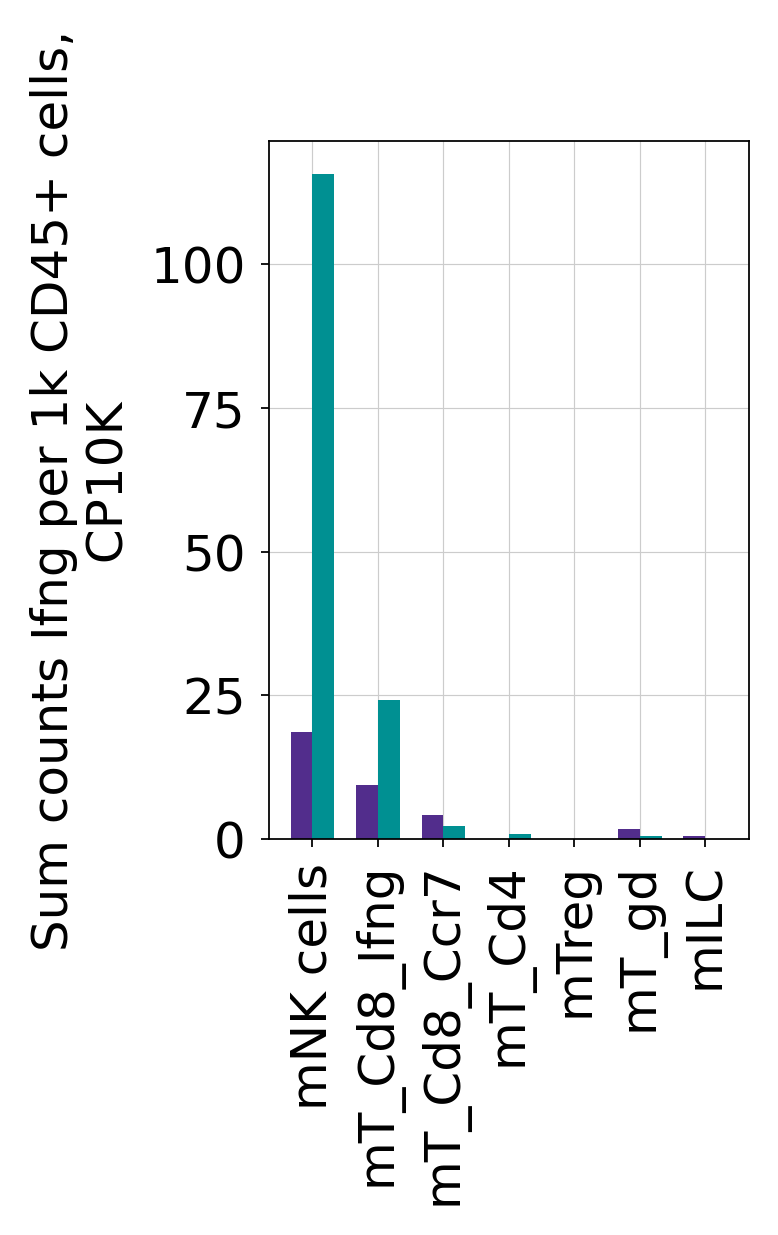

In [548]:
plot_list = []
for state in states:
    for condition in conditions: 
        plot_list.append(sums[state][condition])

xs = []
for i in np.arange(1, 1.5*len(plot_list)):
    if i % 3:
        xs.append(i)
    else:
        continue
xs = [i-1 for i in xs]
xticks = np.array(xs[::2])+0.5
colors = []
for i,color in enumerate(itertools.cycle([cg['condition']['label_colors']['Vehicle'], cg['condition']['label_colors']['CSF1Ri']])):
    colors.append(color)
    if i == 2*len(plot_list):
        break 
    
a,fig,gs = rz.startfig(7,10)
a.grid(zorder = -2)
a.bar(xs, plot_list, color = colors, zorder = 2, width = 1)
a.set_xticks(xticks)
a.set_xticklabels(states, rotation = 90) 
a.set_ylabel('Sum counts %s per 1k CD45+ cells,\n CP10K'%'Ifng')
gs.tight_layout(fig)
plt.savefig('./Ifng_secretion.pdf', dpi = 300)

## Plot secretion Il12b in T/NK cell states

In [549]:
states = ['mDC1', 'mDC2', 'mDC3']

In [550]:
sums = dd(dict)
for state in states: 
    for condition in conditions:
        sums[state][condition] = (adata[cmask][(adata[cmask].obs['condition'] == condition) & (adata[cmask].obs['*population_alt_T_6'] == state), 'Il12b'].X.sum()/sumcells[condition])*1000

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


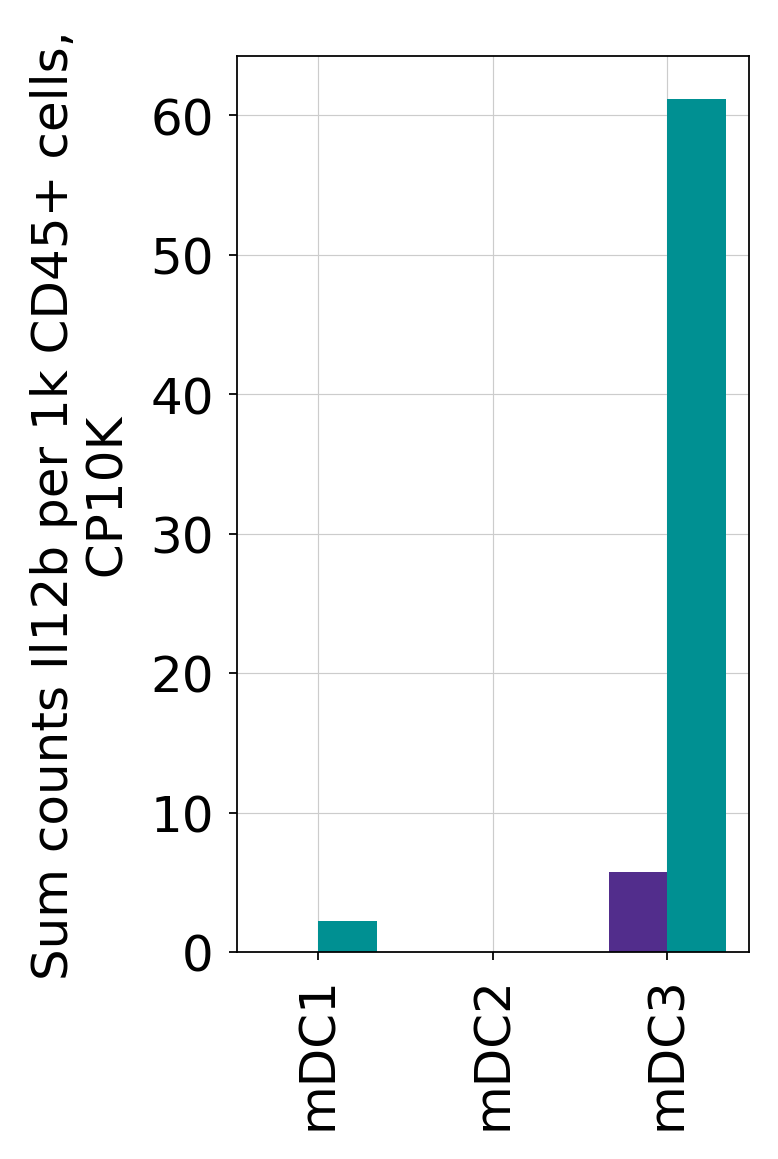

In [551]:
plot_list = []
for state in states:
    for condition in conditions: 
        plot_list.append(sums[state][condition])
        
xs = []
for i in np.arange(1, 1.5*len(plot_list)):
    if i % 3:
        xs.append(i)
    else:
        continue
xs = [i-1 for i in xs]
xticks = np.array(xs[::2])+0.5
colors = []
for i,color in enumerate(itertools.cycle([cg['condition']['label_colors']['Vehicle'], cg['condition']['label_colors']['CSF1Ri']])):
    colors.append(color)
    if i == 2*len(plot_list):
        break 
    
a,fig,gs = rz.startfig(7,10)
a.grid(zorder = -2)
a.bar(xs, plot_list, color = colors, zorder = 2, width = 1)
a.set_xticks(xticks)
a.set_xticklabels(states, rotation = 90) 
a.set_ylabel('Sum counts %s per 1k CD45+ cells,\n CP10K'%'Il12b')
gs.tight_layout(fig)
plt.savefig('./Il12b_secretion.pdf', dpi = 300)

## Fig. S2A

In [541]:
xy = pd.read_csv('data/from_spring_all_Cd45pos_cells/coordinates.txt',header=None,index_col=0)

In [65]:
# check if cell numbers match
cmask.sum() == xy.shape[0]

True

In [66]:
shuffle_adata = adata[cmask].copy()

In [71]:
rng = np.random.default_rng()
arr = np.arange(shuffle_adata.shape[0])
rng.shuffle(arr)

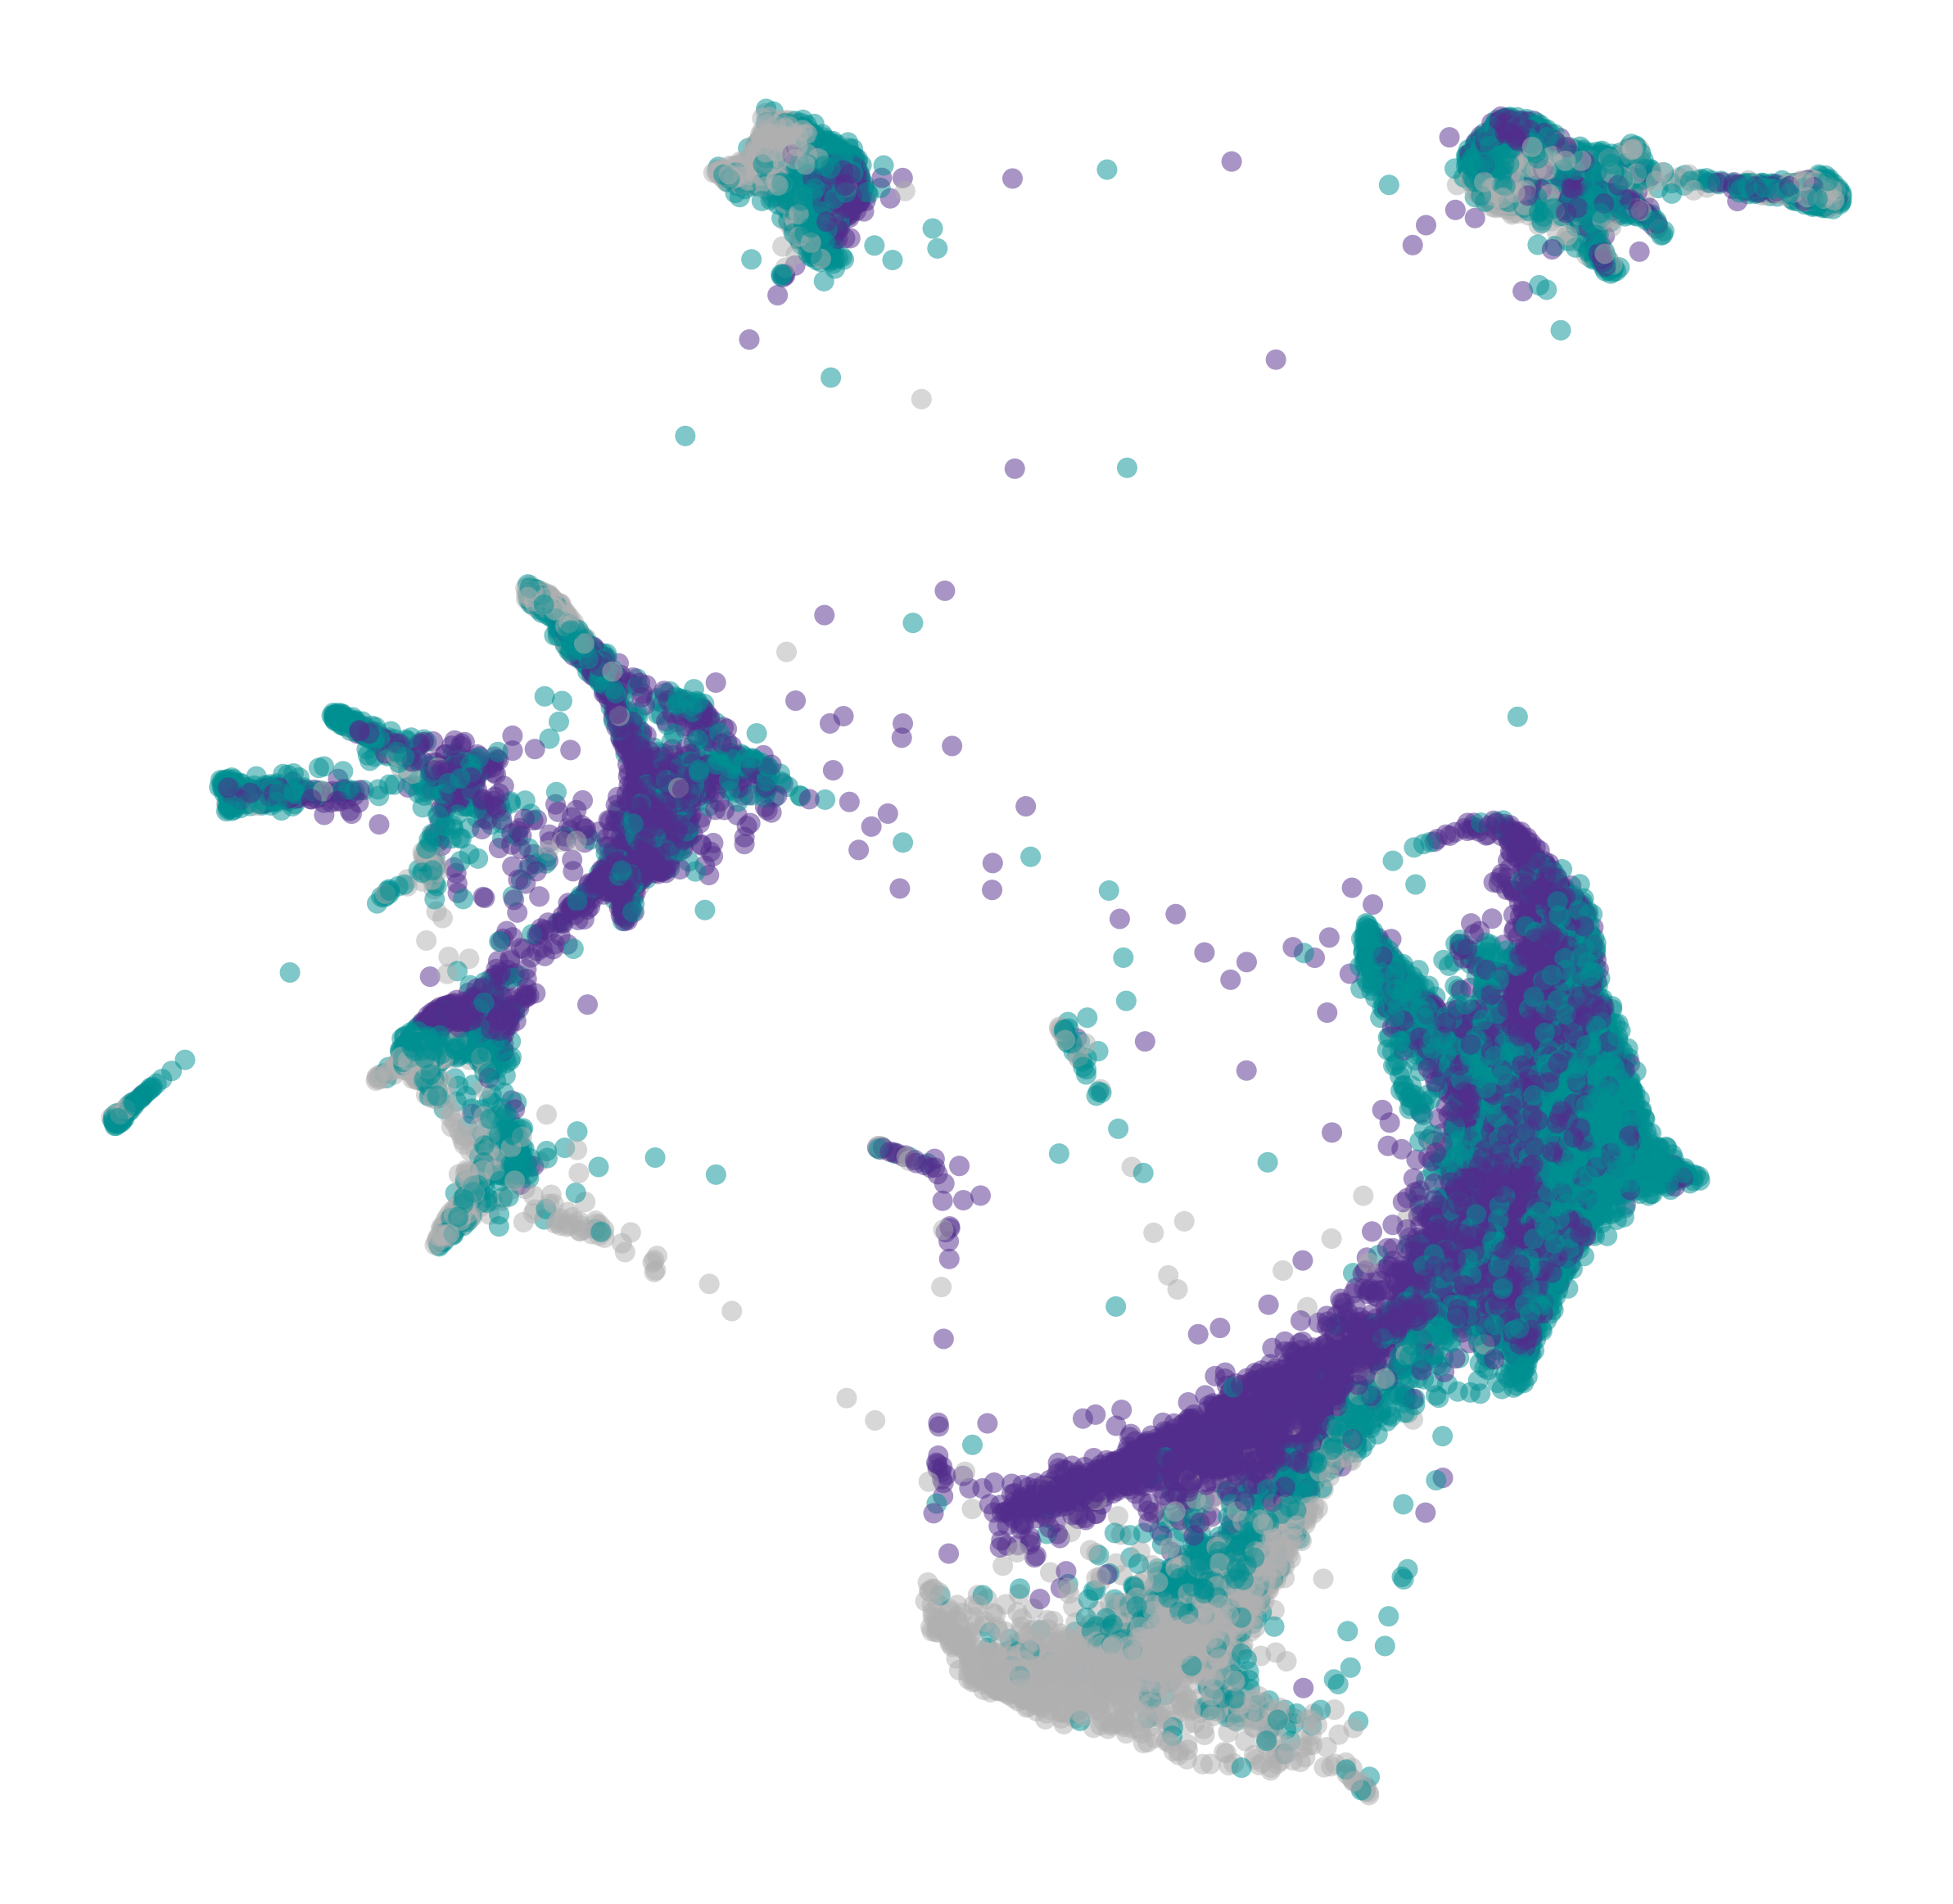

In [77]:
x = xy.iloc[arr,0].values
y = -xy.iloc[arr,1].values #flipped for some reason...

colors = [cg['condition']['label_colors'][i] for i in shuffle_adata[arr].obs['condition']]
#np.random.shuffle(colors)

fig = plt.figure(figsize=(10,10))
a = fig.add_subplot(1,1,1,frameon=False)
a.scatter(x,y,color=colors,lw=0, alpha = 0.5)

a.set_xticks([])
a.set_yticks([])
plt.savefig('figures/fig_S2A.pdf', dpi = 300)

## Fig. S2E 

In [45]:
# Count number of cells in each condition
countDf = adata[cmask, :].obs.loc[:, ['mouse', "*population", 'condition']].groupby(['mouse', "*population"]).count()
countDf.columns = ['count']

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [46]:
# Calculate the percentages of each cell type and put into dict with key = mouse & values is pd.Series with index = *population & values percentage
percentDict = {}
for replicate in countDf.index.get_level_values('mouse').unique():
    value = countDf.loc[replicate]/countDf.loc[replicate].sum()*100.
    value.columns = ['percentage']
    percentDict[replicate] = value

In [47]:
# Subset percent dict with states to plot and fill absent categories with 0
toplot = ['Mono1', 'Mono2', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC']
#toplot = ['DC1', 'DC2', 'DC3']
#toplot = ['T cells', 'NK cells']
#toplot = ['B cells']

# Create a dict with keys = replicates and values = df reindexed in the right order of toplot and with NA = 0 
mamoPercentDict = {}
for replicate,value in percentDict.items():
    mamoPercentDict[replicate] = value.reindex(toplot).fillna(0)

mamoPercentDictT = {}
# Convert value df to 1D numpy array 
for replicate in mamoPercentDict:
    print(replicate)
    mamoPercentDictT[replicate] = mamoPercentDict[replicate].values.flatten() 

CSF1Ri_1
CSF1Ri_2
Healthy_1
Healthy_2
Vehicle_1
Vehicle_2


In [37]:
replicateDict = {'Vehicle': ['Vehicle_1','Vehicle_2'],
                 'CSF1Ri': ['CSF1Ri_1','CSF1Ri_2'],
                 'Healthy': ['Healthy_1', 'Healthy_2']
                }

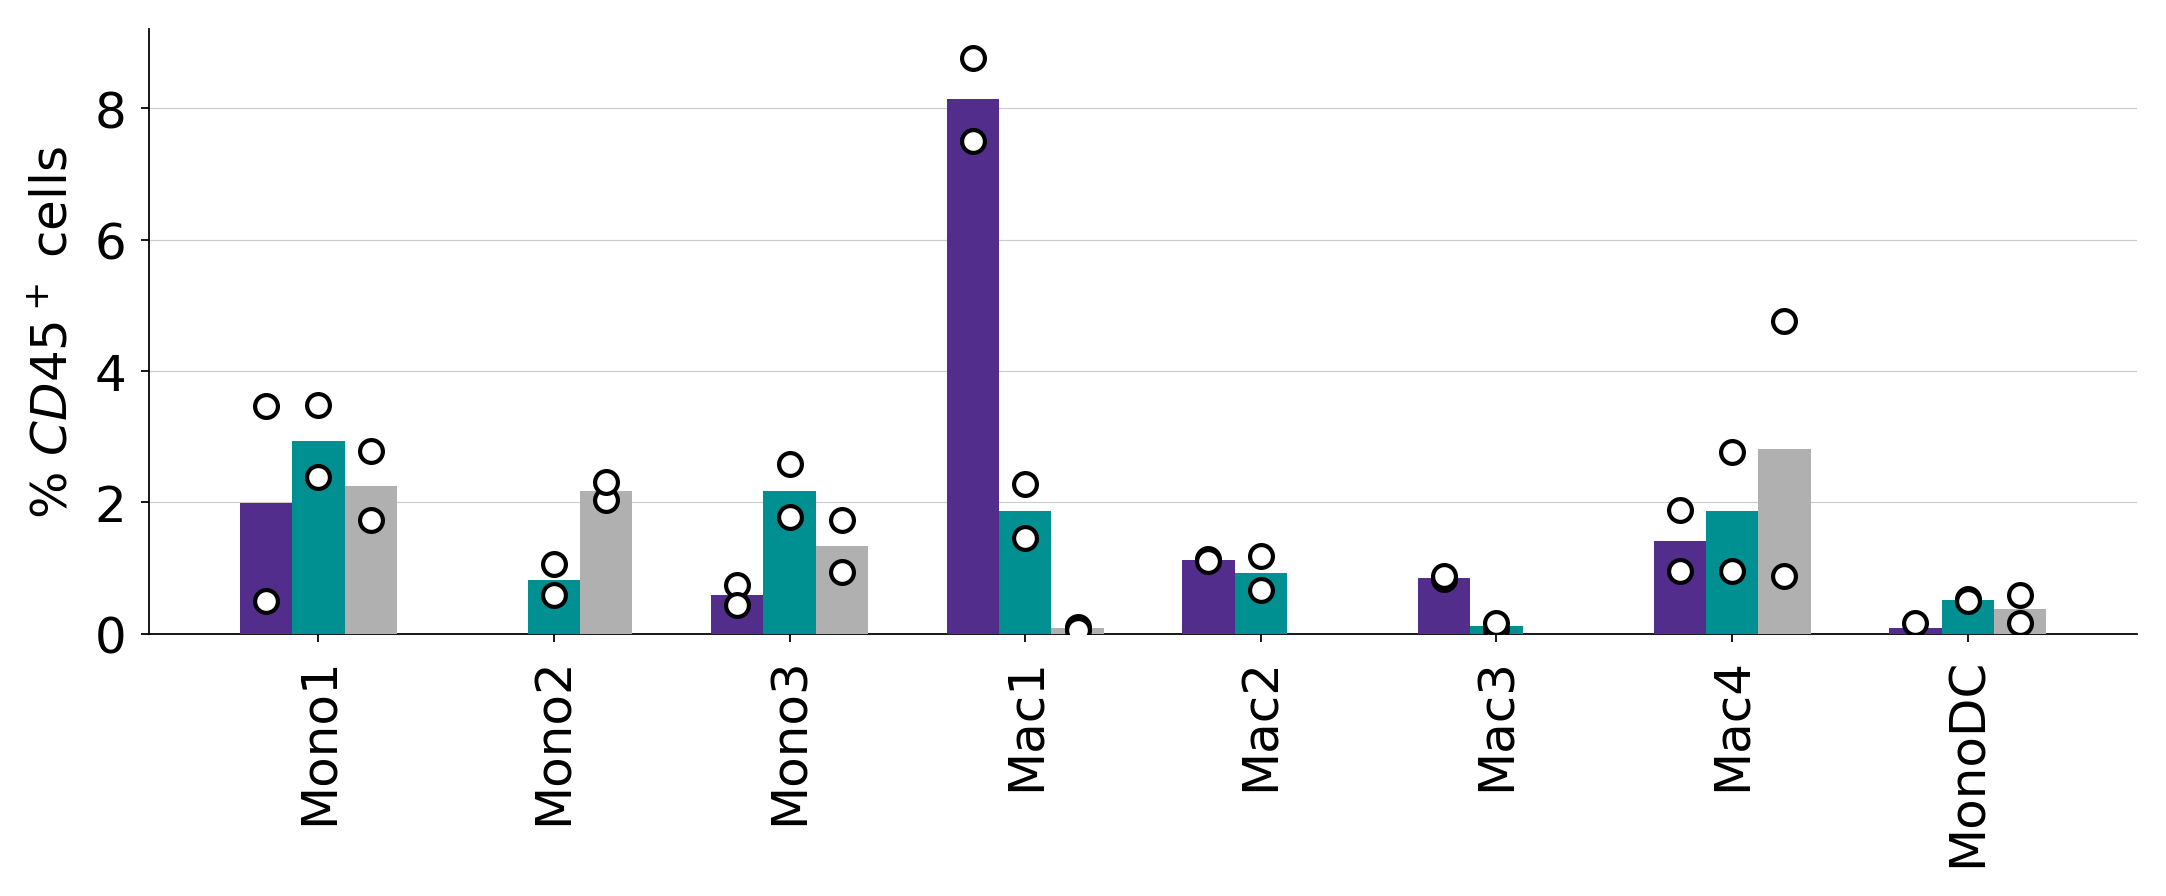

In [83]:
bar_scatter_rep(mamoPercentDictT, replicateDict, state = True, edgecolor = 'black', color_scatter = 'white',
                space = 1.5, width = 0.5, h = 8, dotsize = 30, cmap_condition = cg['condition']['label_colors'], 
                legend = False, xTicksLabs = toplot, ylab = r'$\%\ CD45^+$'+' cells', 
                saveName = './figures/fig_S2D.pdf')

## Fig. 2E

In [76]:
# Sum monocyte and macrophage state percentages to get total mononcytes and macrophages percentage per condition 
toplot = ['Mono1', 'Mono2', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC']
momaPct = {}
for replicate,value in percentDict.items():
    momaPct[replicate] = np.array([value.reindex(toplot).fillna(0)['percentage'].sum()])

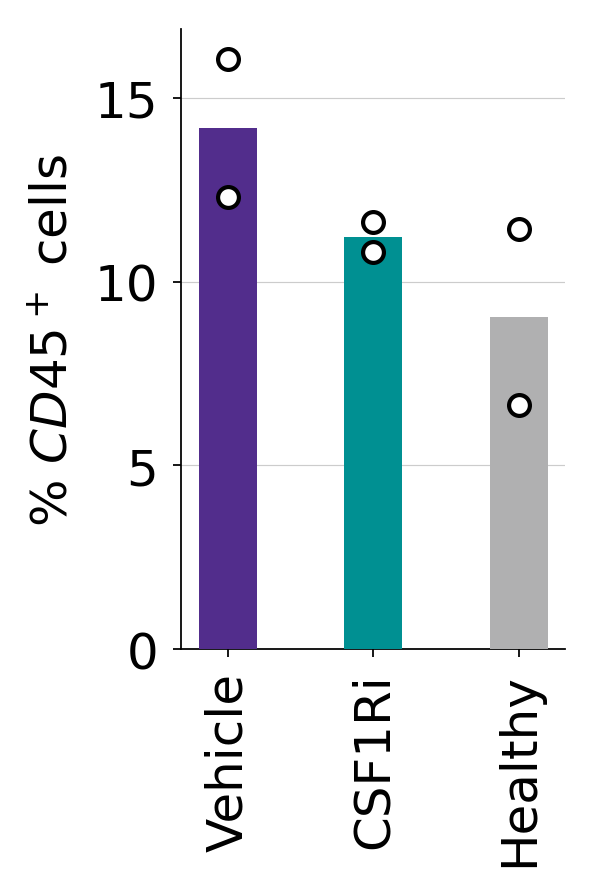

In [85]:
bar_scatter_rep(momaPct, replicateDict, state = False, edgecolor = 'black', color_scatter = 'white',
                space = 1.5, width = 0.65, h = 8, dotsize = 25, cmap_condition = cg['condition']['label_colors'], 
                legend = False, xTicksLabs = toplot, ylab = r'$\%\ CD45^+$'+' cells', 
                saveName = 'figures/fig2F.pdf')

### Fig. 2F

In [115]:
# Subset percent dict with states to plot and fill not detected states with 0
toplot = ['Mono1', 'Mono2', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC']

# Create a dict with keys = replicates and values = df reindexed in the right order of toplot and with NA = 0 
mamoPercentDict = {}
for replicate,value in percentDict.items():
    mamoPercentDict[replicate] = value.reindex(toplot).fillna(0)

In [116]:
# Create a Df with columns the conditions to plot and rows the monocytes and macrophages states
cols1 = replicateDict['Vehicle']
cols2 = replicateDict['CSF1Ri']
VehBlzDf = pd.concat([mamoPercentDict[i] for i in cols1+cols2],axis=1)
VehBlzDf.columns = cols1+cols2
colors = [cg['*population']['label_colors'][i] for i in toplot]

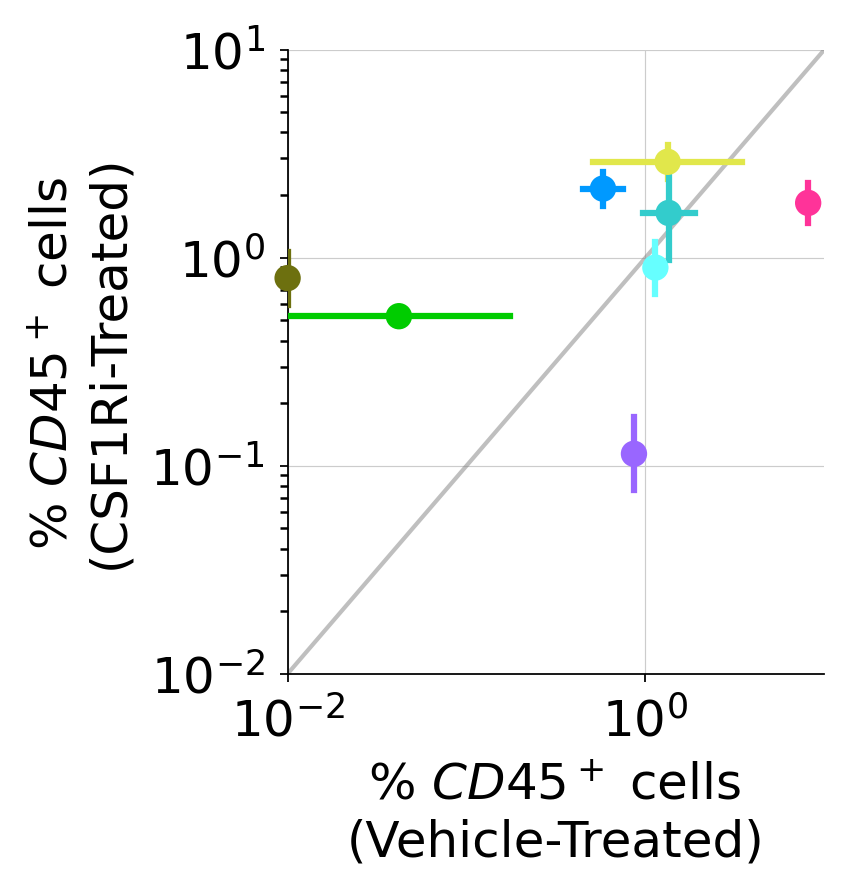

In [125]:
# log
pseudopct = 0.01
upper = 10
pop_abundance_scatter(VehBlzDf+pseudopct,cols1,cols2,
                      w=8,h=8,
                      logscale=True,
                      colors = colors,xlims=[pseudopct,upper],ylims=[pseudopct,upper],diag=upper,
                      xlabel= r'$\%\ CD45^+$'+' cells \n(Vehicle-Treated)',
                      ylabel= r'$\%\ CD45^+$'+' cells \n(CSF1Ri-Treated)',
                      save=True,savedir='Figures/',
                      dotsize=40, lw = 1.5)

## Fig. S2C

In [143]:
# Determine FC higher expression Csf1r in Monocytes/Macrophages states merged VS all other states
print(adata[cmask][adata[cmask].obs['Major cell type'] == 'Monocytes/Macrophages', 'Csf1r'].X.mean())
print(adata[cmask][adata[cmask].obs['Major cell type'] != 'Monocytes/Macrophages', 'Csf1r'].X.mean())
round(adata[cmask][adata[cmask].obs['Major cell type'] == 'Monocytes/Macrophages', 'Csf1r'].X.mean()/adata[cmask][adata[cmask].obs['Major cell type'] != 'Monocytes/Macrophages', 'Csf1r'].X.mean(), 2)

6.9247417
1.5631285


4.43

In [38]:
genes = ['Csf1r']
replicateSeriesDict = dd(lambda:dd(dict))
replicate_col = 'mouse'
state_col = '*population'

for gene in genes:
    for condition in replicateDict.keys():
        for replicate in replicateDict[condition]: 
            cmask1 = cmask & np.array(adata.obs[replicate_col] == replicate)
            replicateSeriesDict[gene][condition][replicate] = pd.Series(adata[cmask1, gene].X.todense().A1, index = adata[cmask1, ].obs[state_col])

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


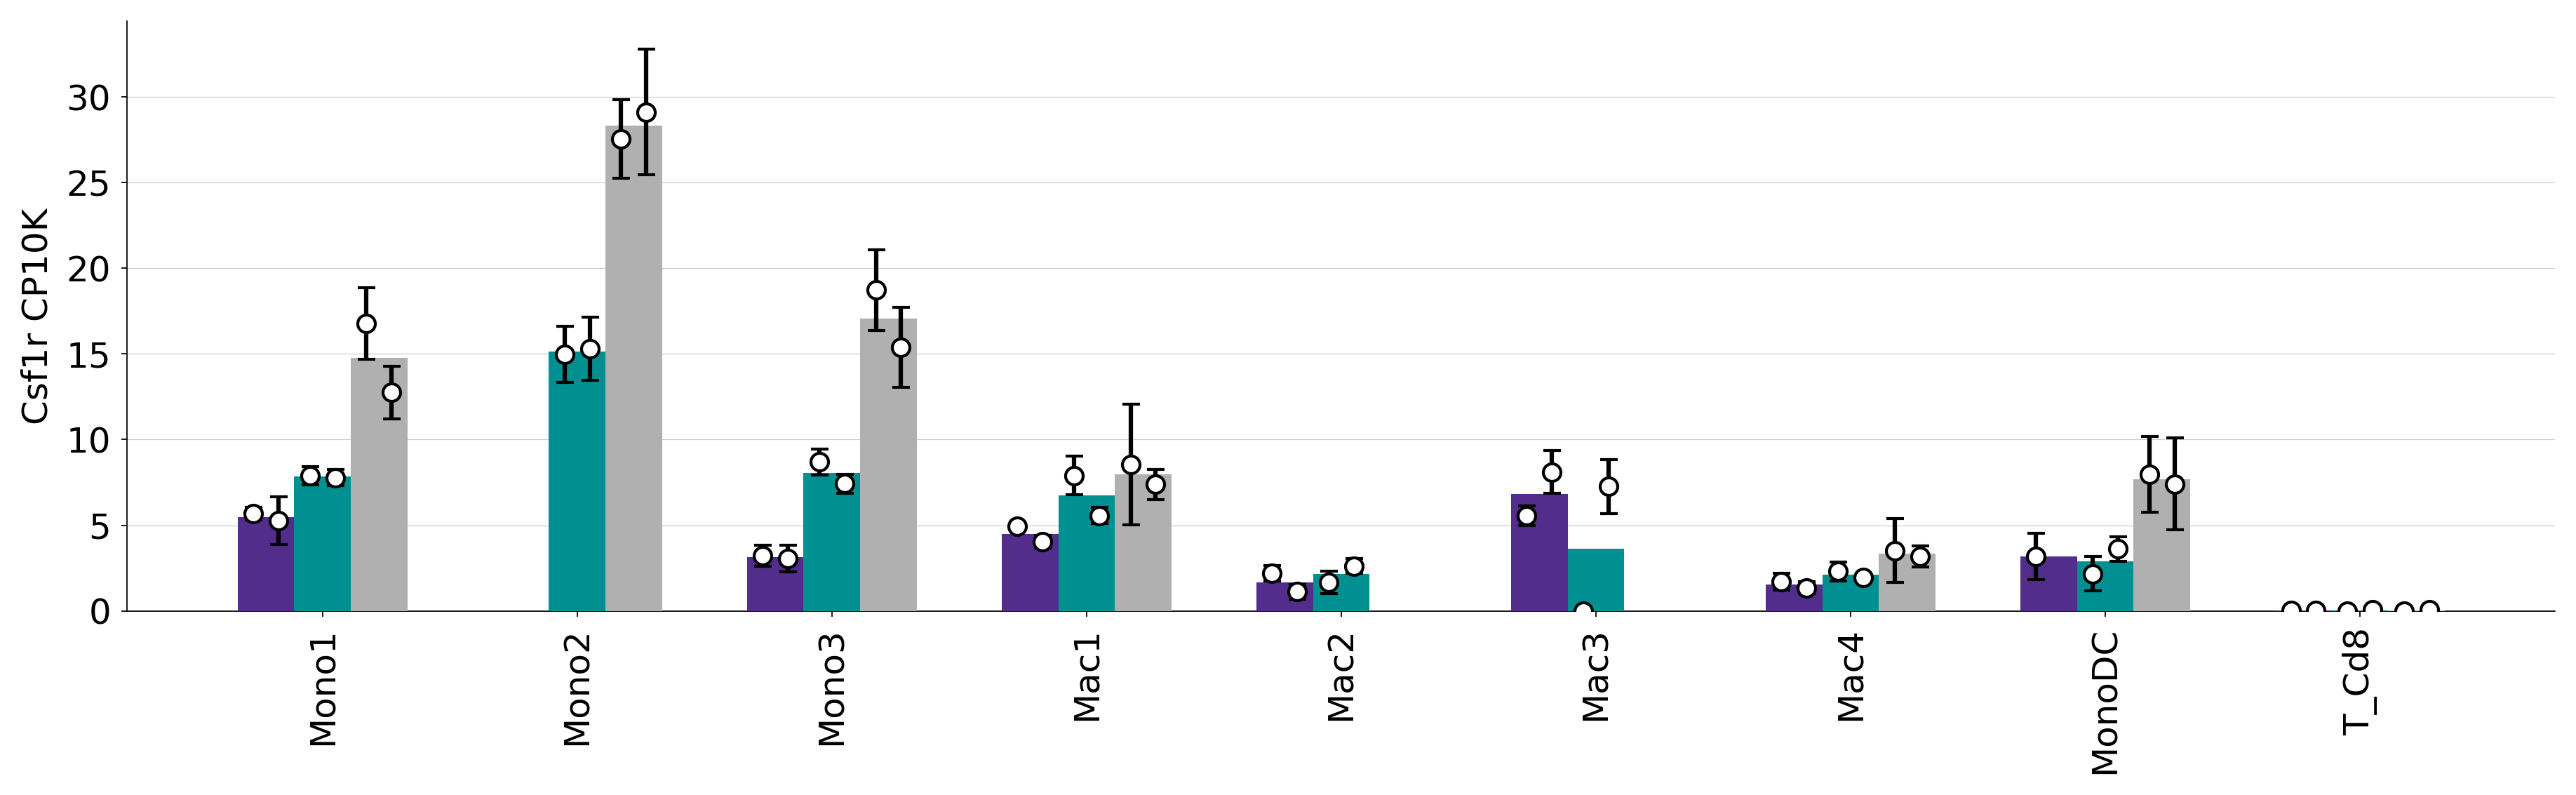

In [39]:
states = ['Mono1', 'Mono2', 'Mono3', 'Mac1', 'Mac2', 'Mac3', 'Mac4', 'MonoDC', 'T_Cd8']
bar_condition_rep_se(replicateSeriesDict['Csf1r'], states = states, cmap_condition = cg['condition']['label_colors'], ylab = 'Csf1r CP10K', h = 10, save = './figures/fig_S2C.pdf')

In [69]:
genes = ['Csf1r']
replicateSeriesDict = dd(lambda:dd(dict))
replicate_col = 'mouse'
state_col = 'Major cell type'

for gene in genes:
    for condition in replicateDict.keys():
        for replicate in replicateDict[condition]: 
            cmask1 = cmask & np.array(adata.obs[replicate_col] == replicate)
            replicateSeriesDict[gene][condition][replicate] = pd.Series(adata[cmask1, gene].X.todense().A1, index = adata[cmask1, ].obs[state_col])

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [70]:
adata.obs['Major cell type'].unique()

array(['B cells', 'NK cells', 'Neutrophils', 'Monocytes/Macrophages',
       'T cells', nan, 'Dendritic cells', 'Basophils', 'ILC'],
      dtype=object)

In [71]:
cell_types = ['Neutrophils', 'Basophils', 'NK cells', 'T cells', 'B cells', 'Monocytes/Macrophages', 'Dendritic cells']

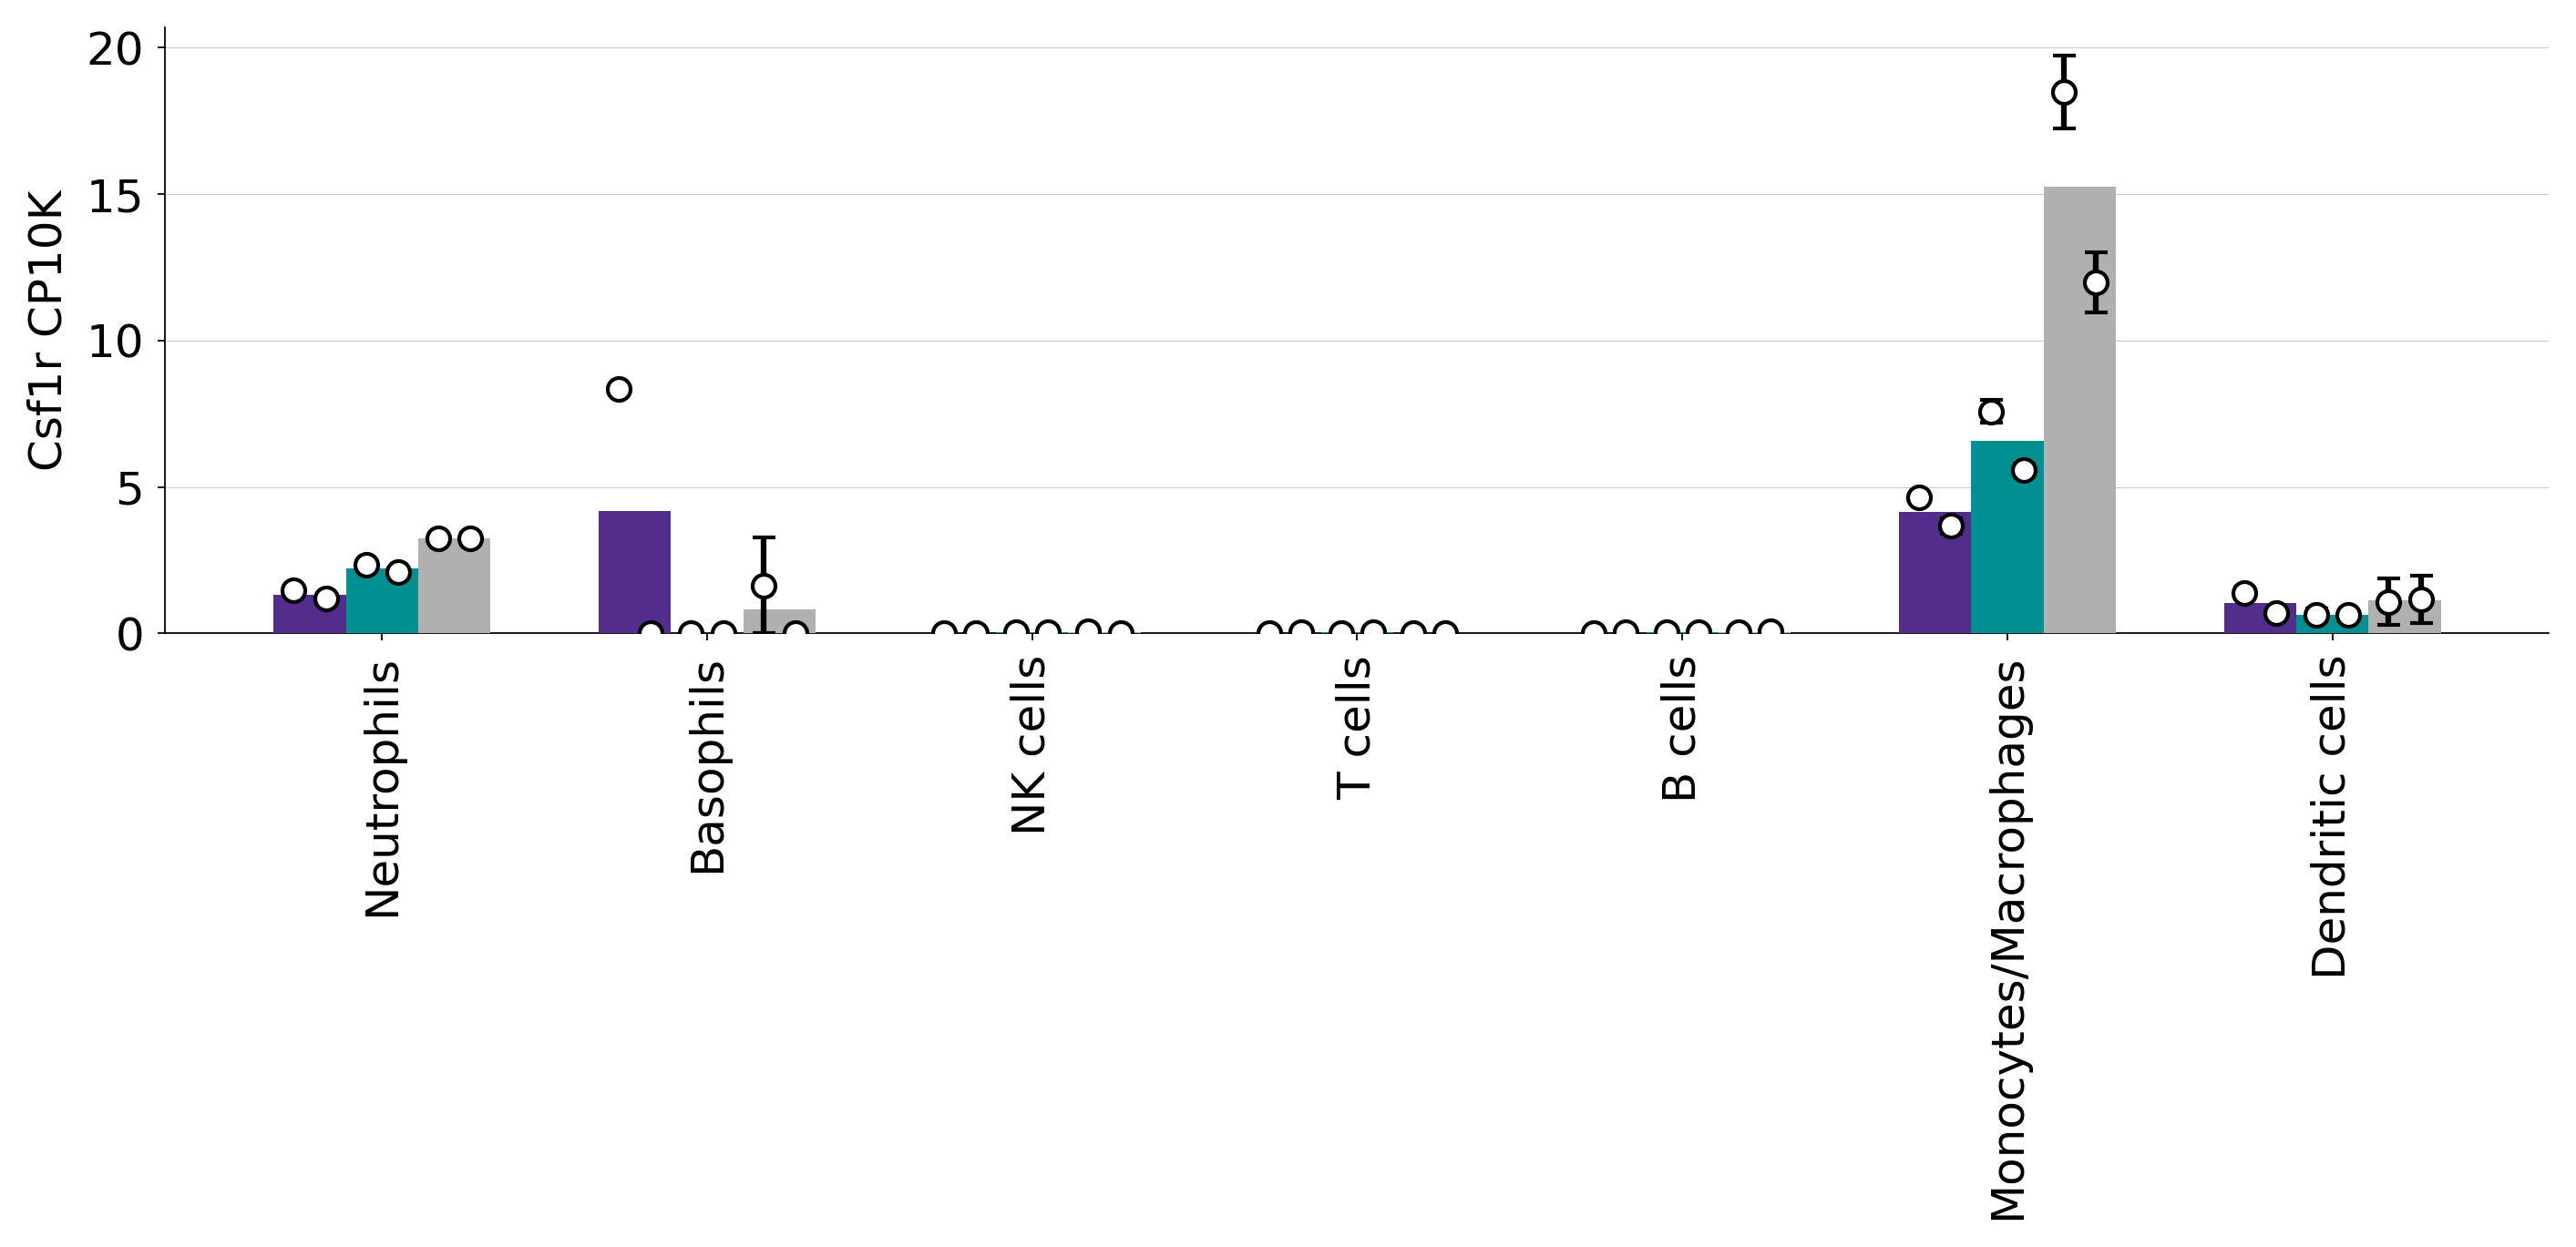

In [72]:
bar_condition_rep_se(replicateSeriesDict['Csf1r'], states = cell_types, cmap_condition = cg['condition']['label_colors'], ylab = 'Csf1r CP10K', h = 12, save = './figures/csf1r_cell_types_with_healthy.pdf')

In [73]:
replicateDict = {'Vehicle': ['Vehicle_1','Vehicle_2'],
                 'CSF1Ri': ['CSF1Ri_1','CSF1Ri_2'],
                }

In [74]:
genes = ['Csf1r']
replicateSeriesDict = dd(lambda:dd(dict))
replicate_col = 'mouse'
state_col = 'Major cell type'

for gene in genes:
    for condition in replicateDict.keys():
        for replicate in replicateDict[condition]: 
            cmask1 = cmask & np.array(adata.obs[replicate_col] == replicate)
            replicateSeriesDict[gene][condition][replicate] = pd.Series(adata[cmask1, gene].X.todense().A1, index = adata[cmask1, ].obs[state_col])

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


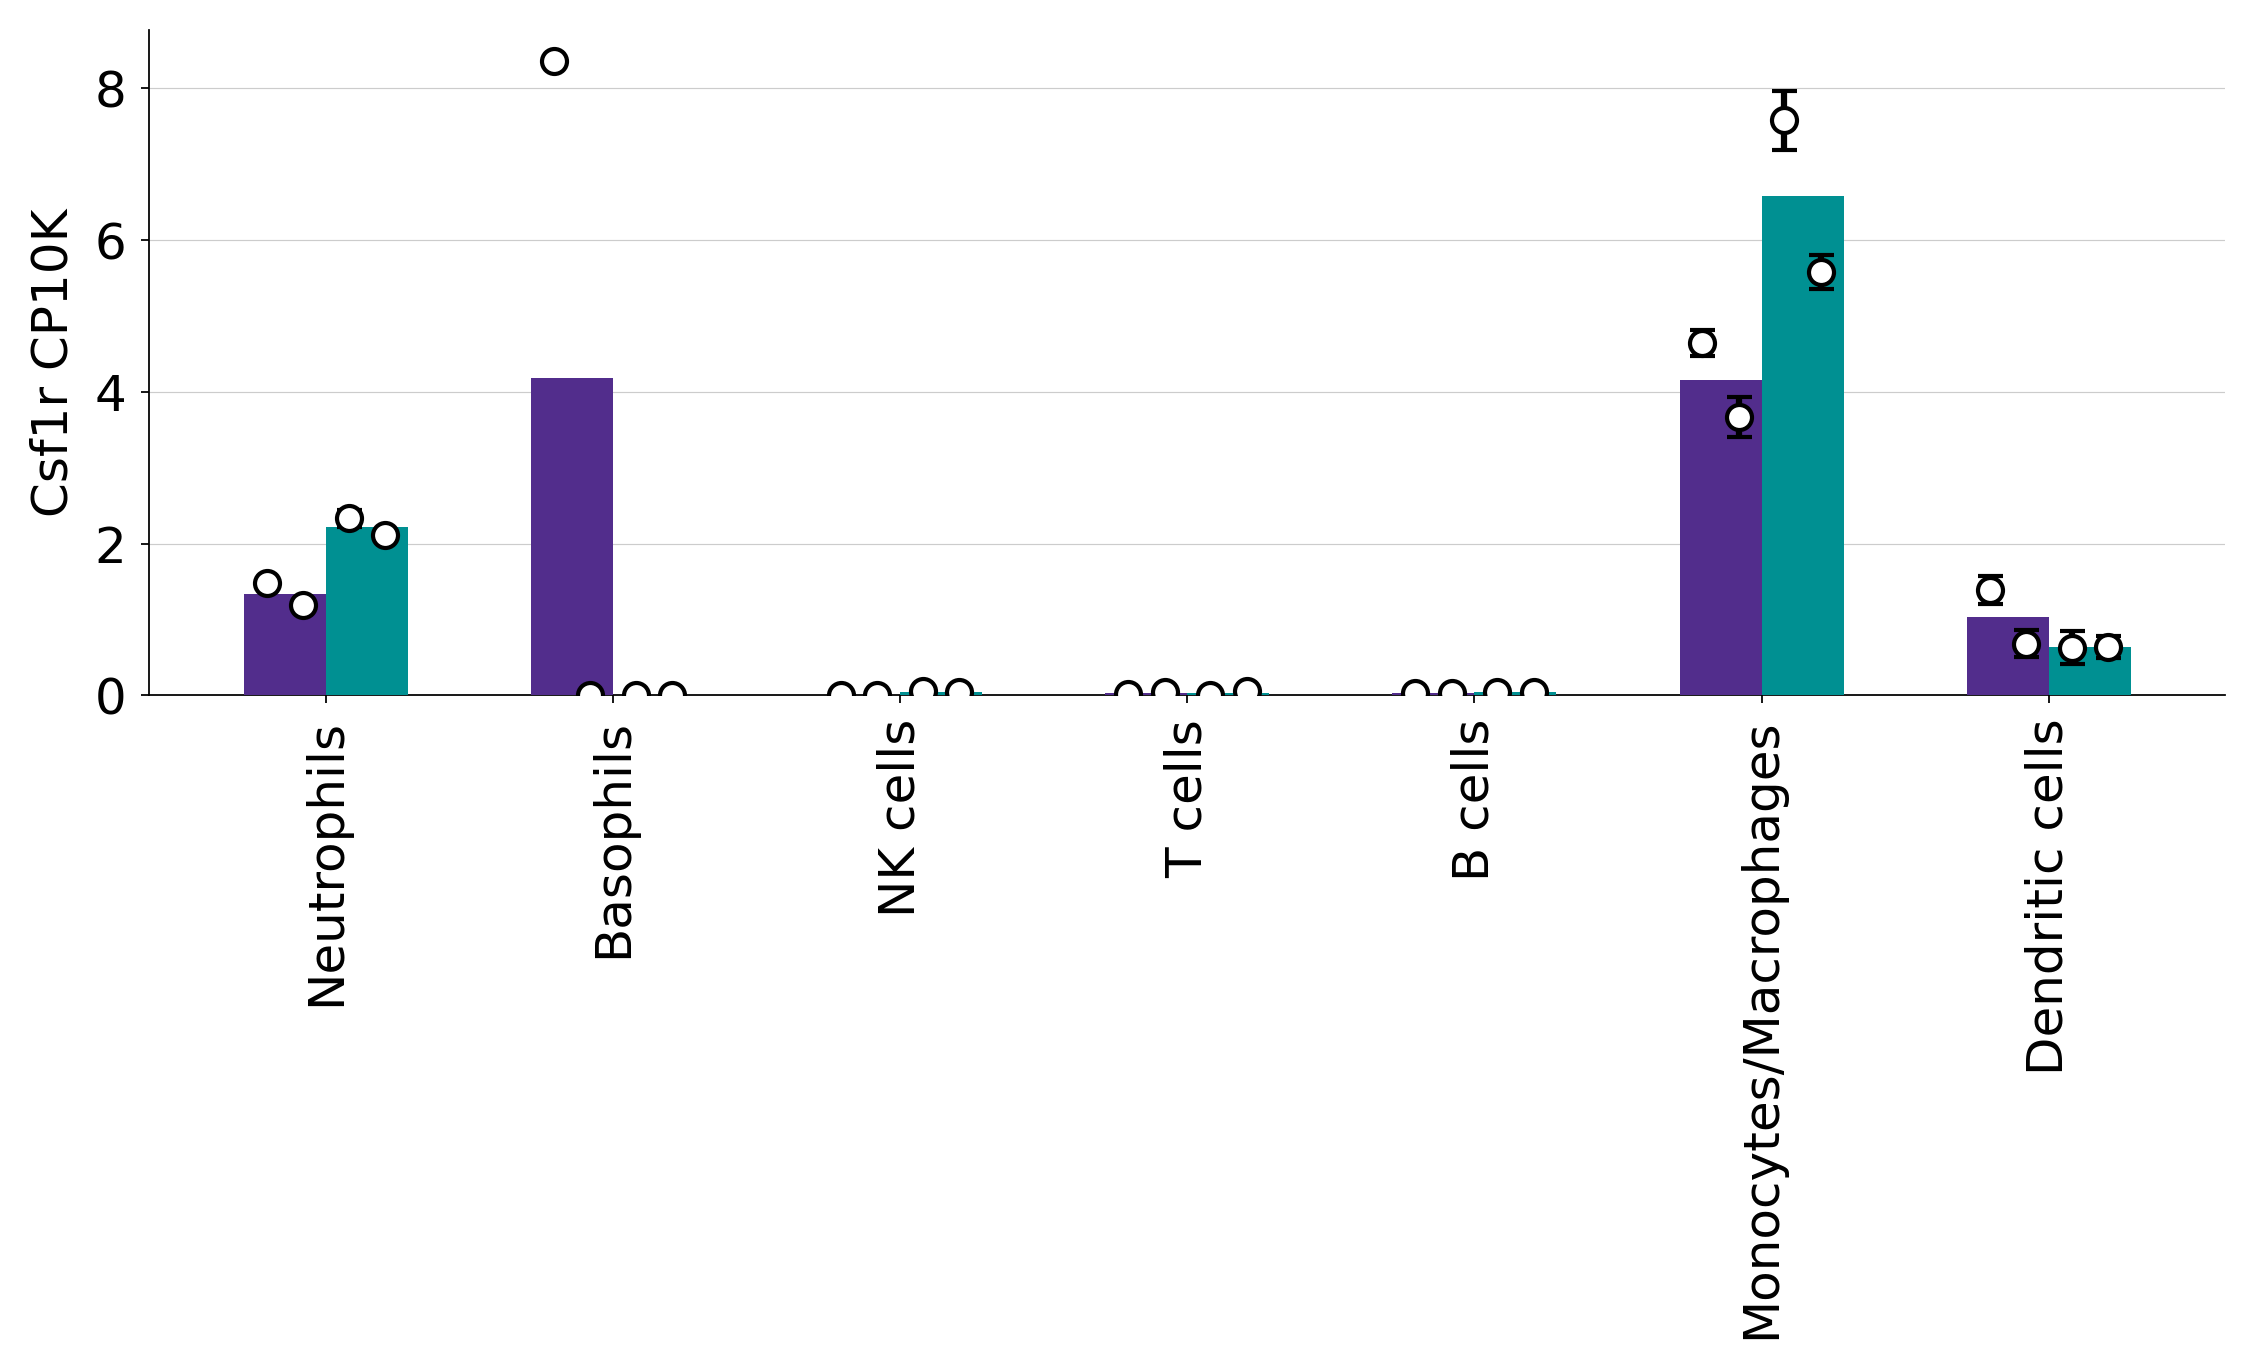

In [75]:
bar_condition_rep_se(replicateSeriesDict['Csf1r'], states = cell_types, cmap_condition = cg['condition']['label_colors'], ylab = 'Csf1r CP10K', h = 12, save = './figures/csf1r_cell_types_without_healthy.pdf')

In [76]:
replicateDict = {'Vehicle': ['Vehicle_1','Vehicle_2'],
                 'CSF1Ri': ['CSF1Ri_1','CSF1Ri_2'],
                 'Healthy': ['Healthy_1', 'Healthy_2']
                }

### Fig. 4G, S4I, S4J, 5F, S5G, and S5H

In [49]:
# Get the centroids for every replicate and write it into a centMouseDict 
centMouseDict = {}
for mouse in adata.obs[cmask]['mouse'].unique():
    print(mouse)
    cmask1 = adata.obs['mouse']==mouse
    cmask1 = cmask1.values
    print(sum(cmask1))
    print(sum(cmask&cmask1))
    centMouseDict[mouse] = rz.centroids("*population", adata[cmask&cmask1]) # Use *population here if you want subtypes

CSF1Ri_1
3228
3019
CSF1Ri_2
7652


/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


6835
Vehicle_1
5820
5440
Vehicle_2
3853
3412
Healthy_1
3320
2948
Healthy_2
3690
3385


In [51]:
# Select states 
#toplot = ['Mono1', 'Mono2', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC', 'T_Cd8', 'T_Cd4']
#toplot = ['Mono1', 'Mono2', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC']
#toplot = ['Mono1', 'Mono3','Mac1', 'Mac2', 'Mac3', 'Mac4','MonoDC']
#toplot = ['T_Cd4', 'T_Cd8', 'NK cells']
#toplot = ['T_Cd4', 'T_Cd8']
#toplot = ['DC1', 'DC2', 'DC3']
#toplot = ['T_Cd8', 'NK cells']
#toplot = ['B cells']

subCentMouseDict = {}
for replicate,value in centMouseDict.items():
    subCentMouseDict[replicate] = value.reindex(toplot).fillna(0)
    
# Create a dict with keys = replicates and values = df reindexed in the right order of toplot and with NA = 0 
mamoPercentDict = {}
for replicate,value in percentDict.items():
    mamoPercentDict[replicate] = value.reindex(toplot).fillna(0)

In [52]:
replicateDict = {'Vehicle': ['Vehicle_1','Vehicle_2'],
                 'CSF1Ri': ['CSF1Ri_1','CSF1Ri_2']
                 #'Healthy': ['Healthy_1', 'Healthy_2']
                }

#genes = ['Csf1r','Cd163', 'Arg1', 'Mrc1', 'Trem2']
#genes = ['Nos2', 'Il12b', 'Cd80', 'Tlr4']
#genes = ['Il12b']
#genes = ['Tgfb1', 'Tgfbr2']
#genes = ['Cx3cr1', 'Ccl9', 'Apoe', 'Cd74', 'Arg1', 'Marco']
#genes = ['Il12b', 'Clec9a', 'Ccr2', 'Cd209a', 'Ciita', 'Irf8', 'Tlr3', 'Ccl22', 'Cd83', 'Fcgr2b', 'Fcgr3']
#genes = ['Ifng', 'Tbx21', 'Prf1']
#genes =  ['Cd96']
#genes = ['Bcl6', 'Pou2af1', 'Mef2c', 'Myc', 'Spib', 'Dock8', 'Bach2', 
    #     'Cd83', 'Cd40', 'Ccr7','Ccr6', 'Cxcr5', 'Tmem123', 'Cd55', 
    #     'Xist', 'Ms4a1', 'Ly6d', 'Ly6e', 'Irf4']

VehBlzDict = dd(lambda:dd())

for gene in genes: 
    for condition, value in replicateDict.items(): 
        VehBlzDict[gene][condition] = pd.concat([subCentMouseDict[i][gene] for i in value],axis=1).mean(axis = 1)

In [53]:
# Define y = % CD45+ abudance Blz & Veh 
y1 = np.log10(((mamoPercentDict[replicateDict['CSF1Ri'][0]]+mamoPercentDict[replicateDict['CSF1Ri'][1]])/2) + 0.01)
y2 = np.log10(((mamoPercentDict[replicateDict['Vehicle'][0]]+mamoPercentDict[replicateDict['Vehicle'][1]])/2) + 0.01)

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


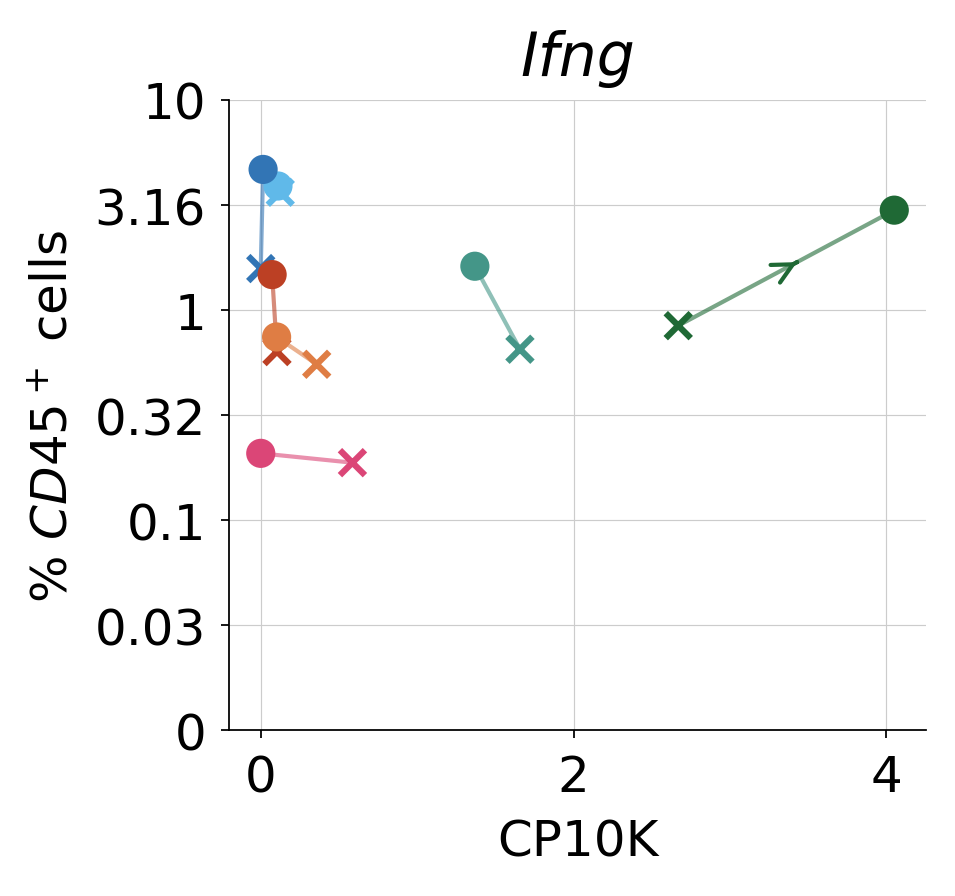

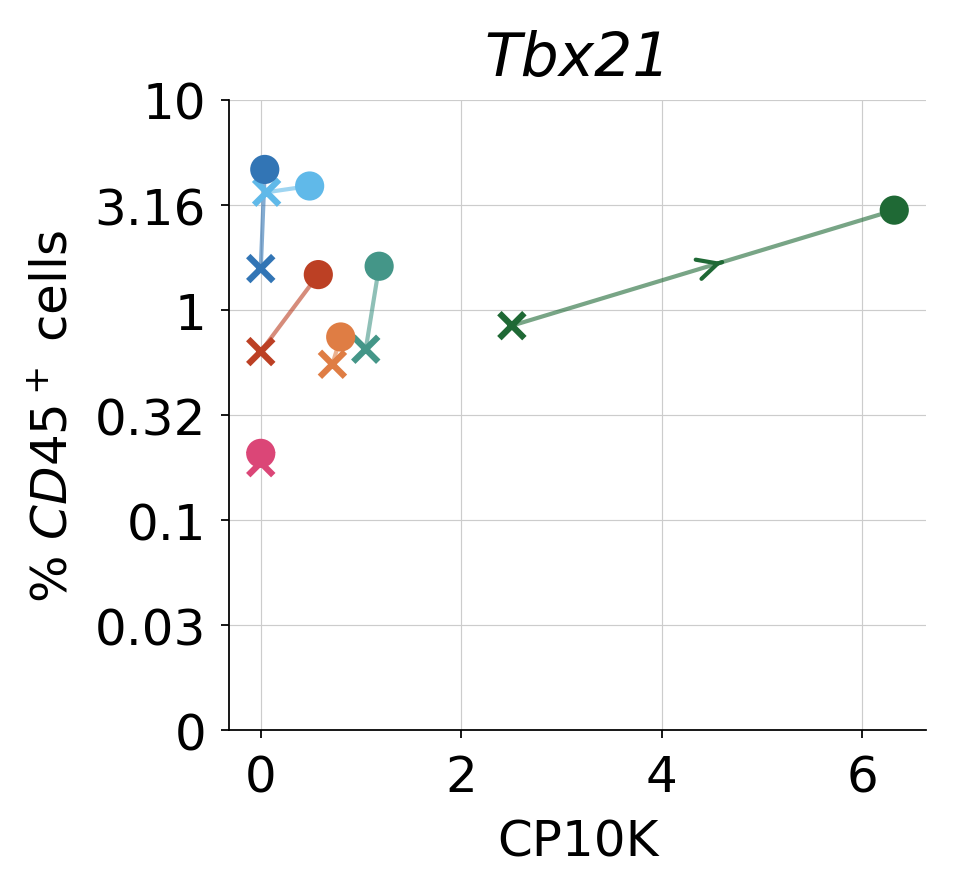

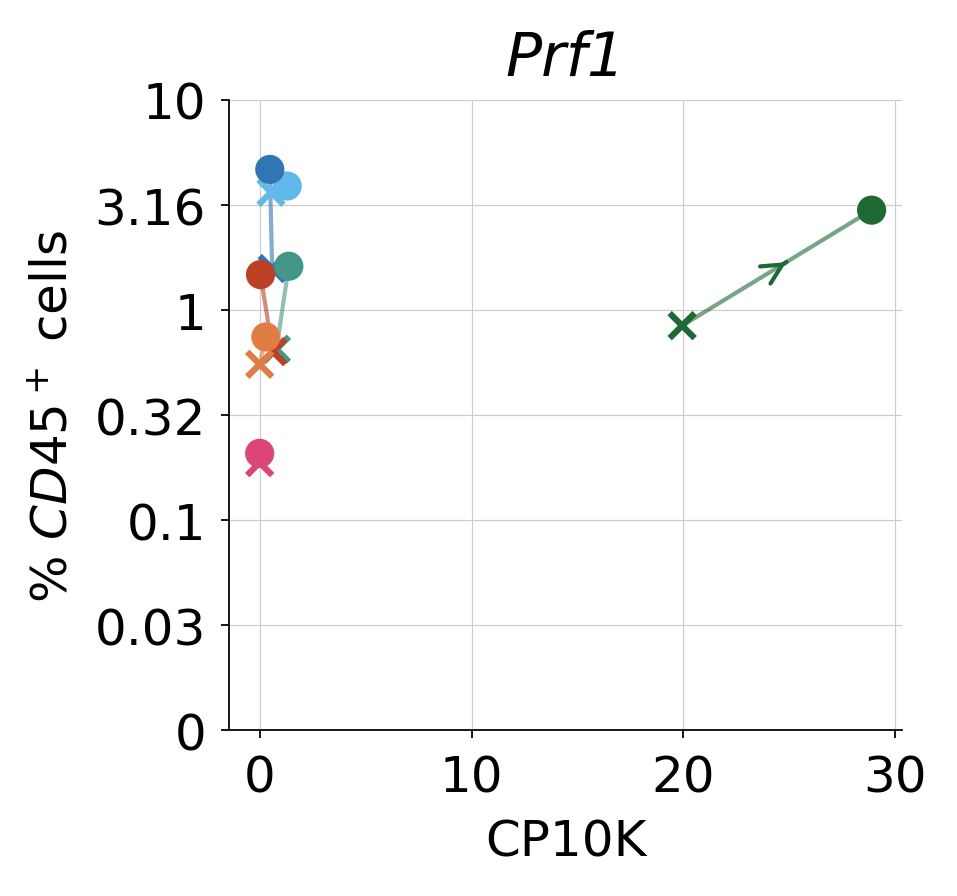

In [55]:
import math
colors = [cg['*population']['label_colors'][i] for i in toplot] 
#colors = ['#449688', '#60B9E9', '#3275B5', '#BC4024', '#DF7D44', '#1f6935', '#DB4677']
for gene in genes:

    for condition, value in VehBlzDict[gene].items():
        if condition == 'CSF1Ri':
            x1 = value
        elif condition == 'Vehicle':
            x2 = value 
            
    a,fig,gs = rz.startfig(8.5,8)
    a.scatter(x=x2, y=y2, label = 'Vehicle', color = colors, alpha = 1,  marker = 'x', zorder = 8, clip_on=False)
    a.scatter(x=x1, y=y1, label = 'CSF1Ri', color = colors, alpha=1, zorder = 8, clip_on=False)
    a.set_ylim(np.log10(0.01), np.log10(10))
    
    for c,mx1,mx2,my1,my2 in zip(colors,x1,x2,y1['percentage'],y2['percentage']):
        a.plot((mx1,mx2),(my1,my2),color=c,lw=1, alpha = 0.6)

        if abs(mx1-mx2) > 0.19*abs(a.get_xlim()[0]-a.get_xlim()[1]) or abs(my1-my2) > 0.19*abs(a.get_ylim()[0]-a.get_ylim()[1]):
            diffx = abs(mx1-mx2)
            diffy = abs(my1-my2)
            #quantiles = [0.85/3, 1.85/3]
            quantiles = [0.45]
            #quantiles = [0.25, 0.5, 0.75]
        
            for quantile in quantiles: 
                if mx1 < mx2 and my1 < my2: 
                    a.annotate('',
                               xy=((mx1 + diffx*quantile*0.9999), (my1 + diffy*quantile*0.9999)),
                               xytext=((mx1 + diffx*quantile), (my1 + diffy*quantile)),  # Add only arrow head with + 0.00001 
                               arrowprops=dict(arrowstyle="->", color=c, alpha = 1)
                              ) 
                elif mx1 > mx2 and my1 < my2: 
                    a.annotate('',
                               xy=((mx1 - diffx*quantile*0.9999), (my1 + diffy*quantile*0.9999)),
                               xytext=((mx1 - diffx*quantile), (my1 + diffy*quantile)),  # Add only arrow head with + 0.00001 
                               arrowprops=dict(arrowstyle="->", color=c, alpha = 1)
                              ) 
                elif mx1 < mx2 and my1 > my2:
                    a.annotate('',
                               xy=((mx1 + diffx*quantile*0.9999), (my1 - diffy*quantile*0.9999)),
                               xytext=((mx1 + diffx*quantile), (my1 - diffy*quantile)),  # Add only arrow head with + 0.00001 
                               arrowprops=dict(arrowstyle="->", color=c, alpha = 1)
                              ) 
                elif mx1 > mx2 and my1 > my2:
                    a.annotate('',
                               xy=((mx1 - diffx*quantile*0.9999), (my1 - diffy*quantile*0.9999)),
                               xytext=((mx1 - diffx*quantile), (my1 - diffy*quantile)),  # Add only arrow head with + 0.00001 
                               arrowprops=dict(arrowstyle="->", color=c, alpha = 1)
                              ) 
                       
    a.set_title(gene, fontstyle = 'italic')
    #a.set_xlim(0,10)
    a.set_yticklabels([0, round(10**-1.5,2), round(10**-1,2), round(10**-0.5,2), round(10**0,2), round(10**0.5,2),  round(10**1,2)])
    a.set_ylabel(r'$\%\ CD45^+$'+' cells')
    a.set_xlabel('CP10K')
    #a.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    rz.showspines(a,bottom=True,left=True)
    a.grid(True, zorder = 0)
    gs.tight_layout(fig)
    plt.savefig('./figures/population_alt_T_6_{}.pdf'.format(gene), dpi=300)        

## Fig. S2F: monocyte and macrophage states DE

In [348]:
# for filtering genes on abundance
min_counts = 5
min_cells = 5

# conditions to compare
condcol = 'condition'
cond1 = 'CSF1Ri'
cond2 = 'Vehicle'

# pseudo value to add for calculating fold-changes
pseudo = 1 #cp10k

# threshold for selecting DGEs
fcts = 2 #fold-change: 2-fold
fdrts = 0.05 # fdr threshold

# adata.obs column where population labels are stored
popcol = '*population'

# populations to compare:
pops = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mono1',
    'Mono2',
    'Mono3',
    'MonoDC',
        ]

# For storing MWU test results
mwudict = {}

# iterate over population
for pop in pops:

    # get mask for selecting all cells for a given population
    popmask = (adata.obs[popcol] == pop).values&cmask
    
    # boolean masks for selecting each population separately:
    mask1 = (adata.obs[condcol] == cond1).values&popmask
    mask2 = (adata.obs[condcol] == cond2).values&popmask
    
    
    print(pop, (mask1|mask2).sum(), 'cells')
    print('\t%s %s: %d cells'%(pop,cond1,mask1.sum()))
    print('\t%s %s: %d cells'%(pop,cond2,mask2.sum()))
    
    
    # filter genes that are lowly expressed. All cells for that population
    # combining both conditions
    gmask = srz.filter_abund_genes(adata.X[(mask1|mask2),:], min_counts, min_cells)
    
    
    cg1 = np.array(adata.X[:,gmask][mask1,:].todense())
    cg2 = np.array(adata.X[:,gmask][mask2,:].todense())
    
    mwures = rz.mwu(cg1,cg2,genes=adata.var_names[gmask],print_progression=True)
    mwures['log2FC'] = np.log2((mwures['mean1']+pseudo)/(mwures['mean2']+pseudo))
    mwures['is_DGE'] = (mwures['log2FC'].abs()>np.log2(fcts))&(mwures['fdr']<fdrts)
    mwures.sort_values(by='log2FC',ascending=False,inplace=True)
    print('%d DGEs (fold-change blz vs veh>%0.1f; FDR<%0.2f) within %s'\
          %(mwures['is_DGE'].sum(), fcts,fdrts,pop))
    
    fname = './DE_analysis/%s_blz_vs_veh.xlsx'%(pop)
    print(fname)
    mwures[mwures['is_DGE']].to_excel(fname)
    mwudict[pop] = mwures
    print()

Mac1 933 cells
	Mac1 CSF1Ri: 200 cells
	Mac1 Vehicle: 733 cells
7176 genes passing abundance filter
1000
2000
3000
4000
5000
6000
7000
8 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mac1
./DE_analysis/Mac1_blz_vs_veh.xlsx

Mac2 201 cells
	Mac2 CSF1Ri: 101 cells
	Mac2 Vehicle: 100 cells
3720 genes passing abundance filter
1000
2000
3000
13 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mac2
./DE_analysis/Mac2_blz_vs_veh.xlsx

Mac3 88 cells
	Mac3 CSF1Ri: 13 cells
	Mac3 Vehicle: 75 cells
1621 genes passing abundance filter
1000
0 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mac3
./DE_analysis/Mac3_blz_vs_veh.xlsx

Mac4 334 cells
	Mac4 CSF1Ri: 218 cells
	Mac4 Vehicle: 116 cells
5373 genes passing abundance filter
1000
2000
3000
4000
5000
33 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mac4
./DE_analysis/Mac4_blz_vs_veh.xlsx

Mono1 474 cells
	Mono1 CSF1Ri: 268 cells
	Mono1 Vehicle: 206 cells
5745 genes passing abundance filter
1000
2000
3000
4000
5000
40 DGEs (fold-cha

/Users/mariusmessemaker/Documents/Project/Csf1Ri_annotated_data_shared/utility_functions_200517_09h14/rz_functions.py:426: RuntimeWarning: Mean of empty slice.
  m2 = cg2.mean(axis=0)
/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/scipy/stats/stats.py:6415: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


1000
2000
0 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mono2
./DE_analysis/Mono2_blz_vs_veh.xlsx

Mono3 254 cells
	Mono3 CSF1Ri: 199 cells
	Mono3 Vehicle: 55 cells
4327 genes passing abundance filter
1000
2000
3000
4000
55 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within Mono3
./DE_analysis/Mono3_blz_vs_veh.xlsx

MonoDC 59 cells
	MonoDC CSF1Ri: 50 cells
	MonoDC Vehicle: 9 cells
1500 genes passing abundance filter
1000
6 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within MonoDC
./DE_analysis/MonoDC_blz_vs_veh.xlsx



In [349]:
# save mwuresult:
stuffname = './DE_analysis/monomac_dge_analysis_results'
rz.save_stuff(mwudict,stuffname)

In [350]:
# test loading
mwudict = rz.load_stuff(stuffname+'.pickle')

In [351]:
# Sort values to give most significant number "1"
for key, value in mwudict.items():
    mwudict[key] = value.sort_values(by = 'fdr')

In [352]:
mwudict['Mac1'][mwudict['Mac1']['is_DGE']==True].head(20)

,U_statistic,p,fdr,mean1,mean2,log2FC,is_DGE
Fkbp5,33030.5,1.417089e-34,1.016903e-30,0.920821,4.296575,-1.463336,True
Chil3,33818.5,5.448093e-32,1.954776e-28,17.832140,72.719963,-1.968858,True
Wfdc21,42148.0,1.126200e-22,2.693871e-19,1.468476,5.865795,-1.475806,True
Klhl6,42469.5,1.250292e-21,1.794419e-18,1.422110,4.520989,-1.188662,True
Lyz2,101006.5,2.361827e-16,2.118558e-13,119.300537,55.993397,1.077776,True
Il1rn,92563.0,1.300835e-10,3.333855e-08,5.343214,1.963722,1.097804,True
Tgm2,91147.0,2.240993e-10,5.187537e-08,5.301322,1.307824,1.449121,True
Retnlg,61206.5,1.832118e-06,1.494009e-04,0.896061,3.830173,-1.349069,True


./DE_analysis/volcano_Mac1_with_names.pdf


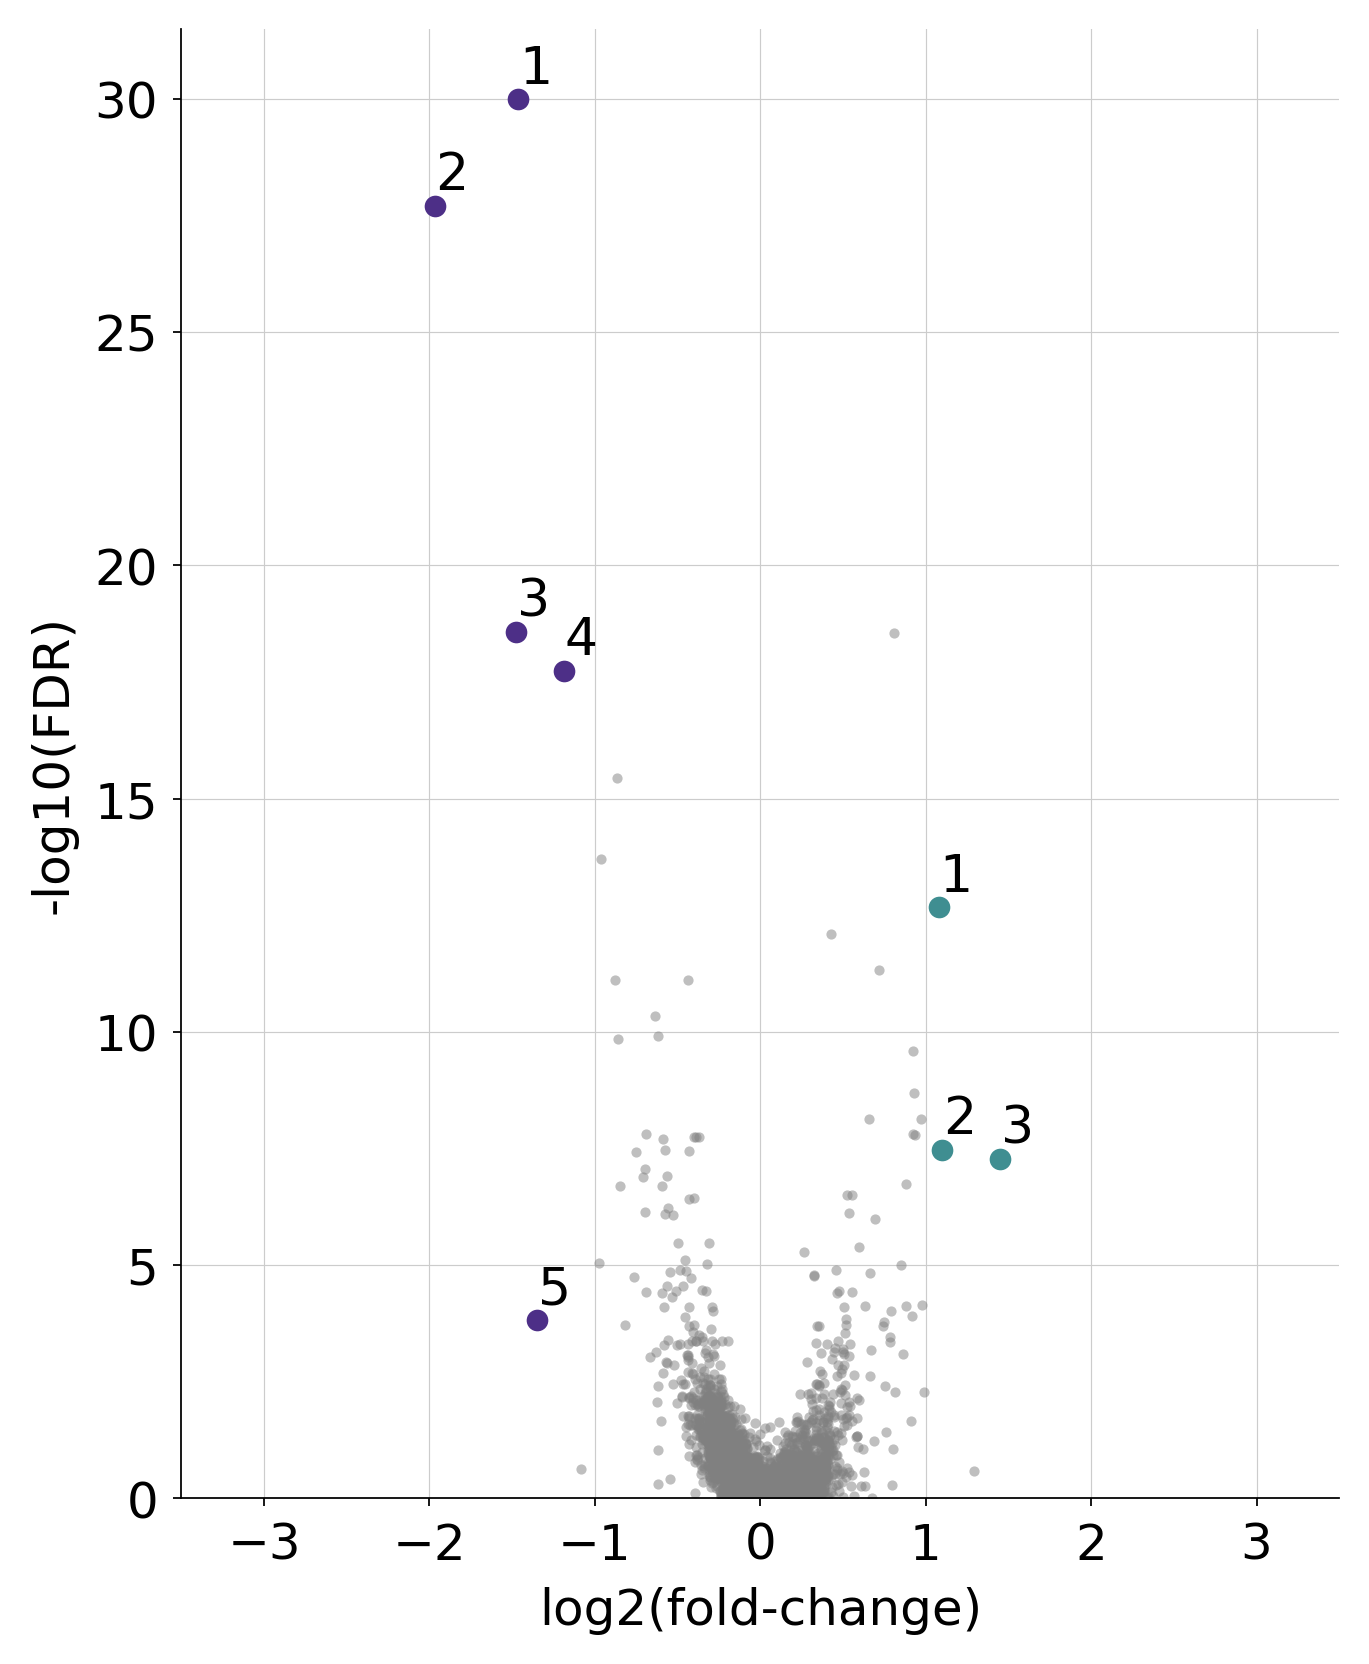

./DE_analysis/volcano_Mac2_with_names.pdf


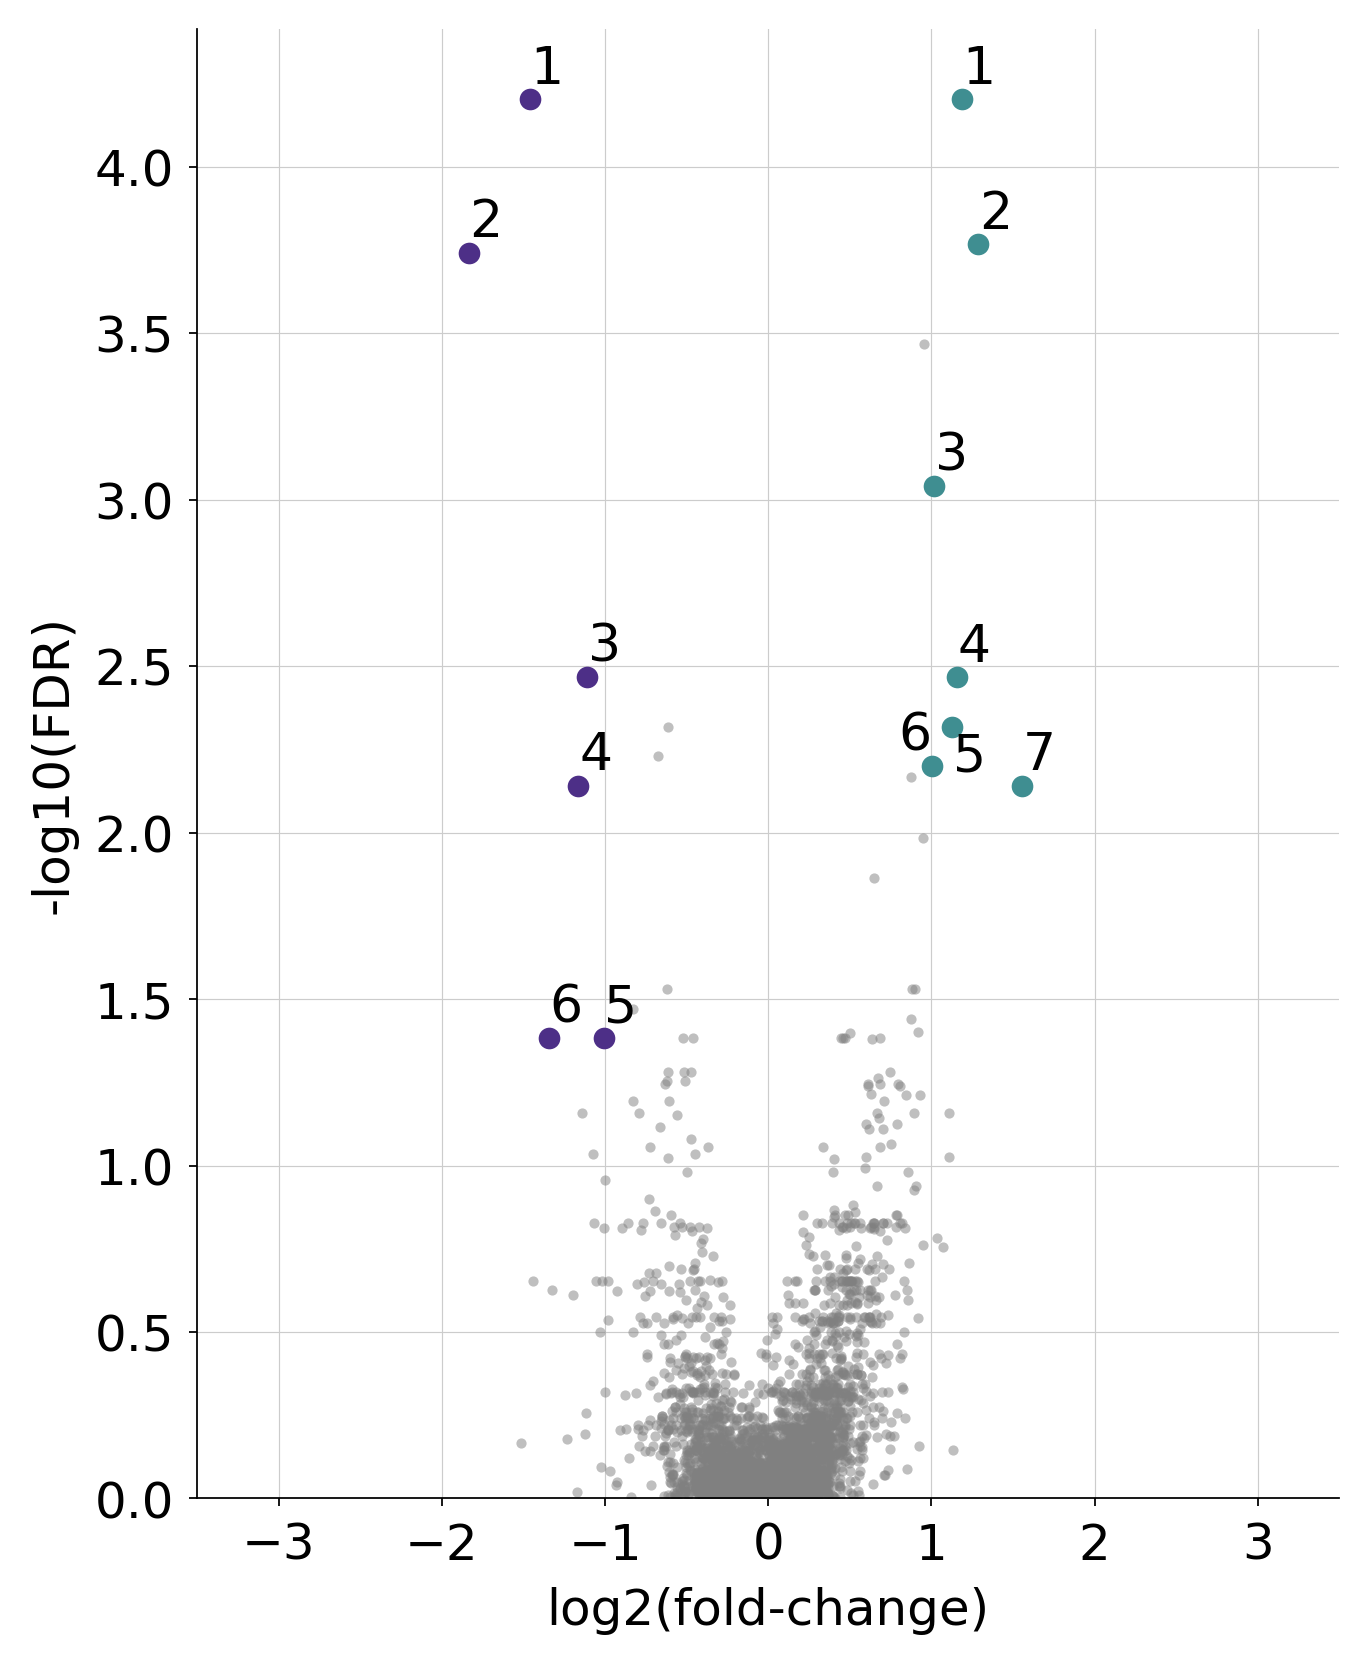

./DE_analysis/volcano_Mac3_with_names.pdf


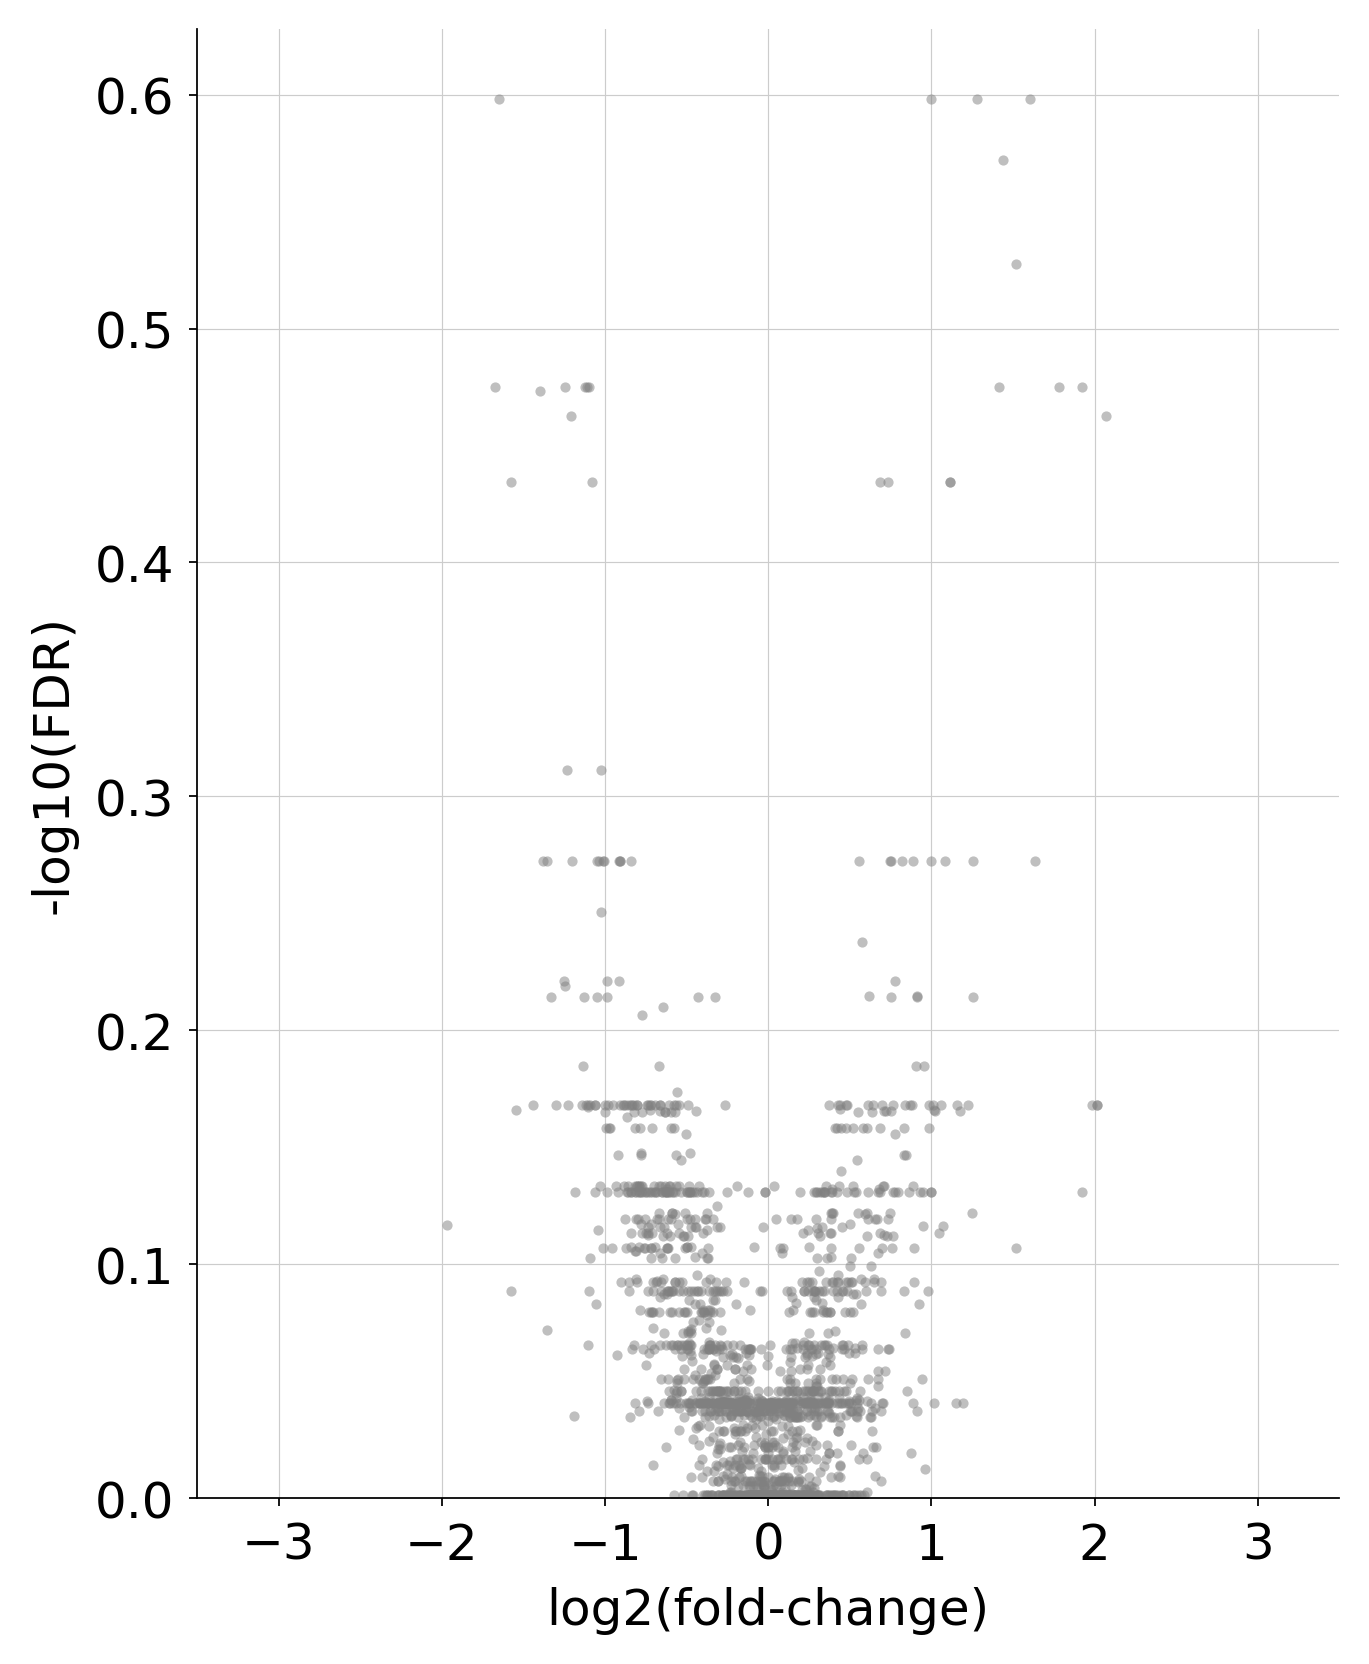

./DE_analysis/volcano_Mac4_with_names.pdf


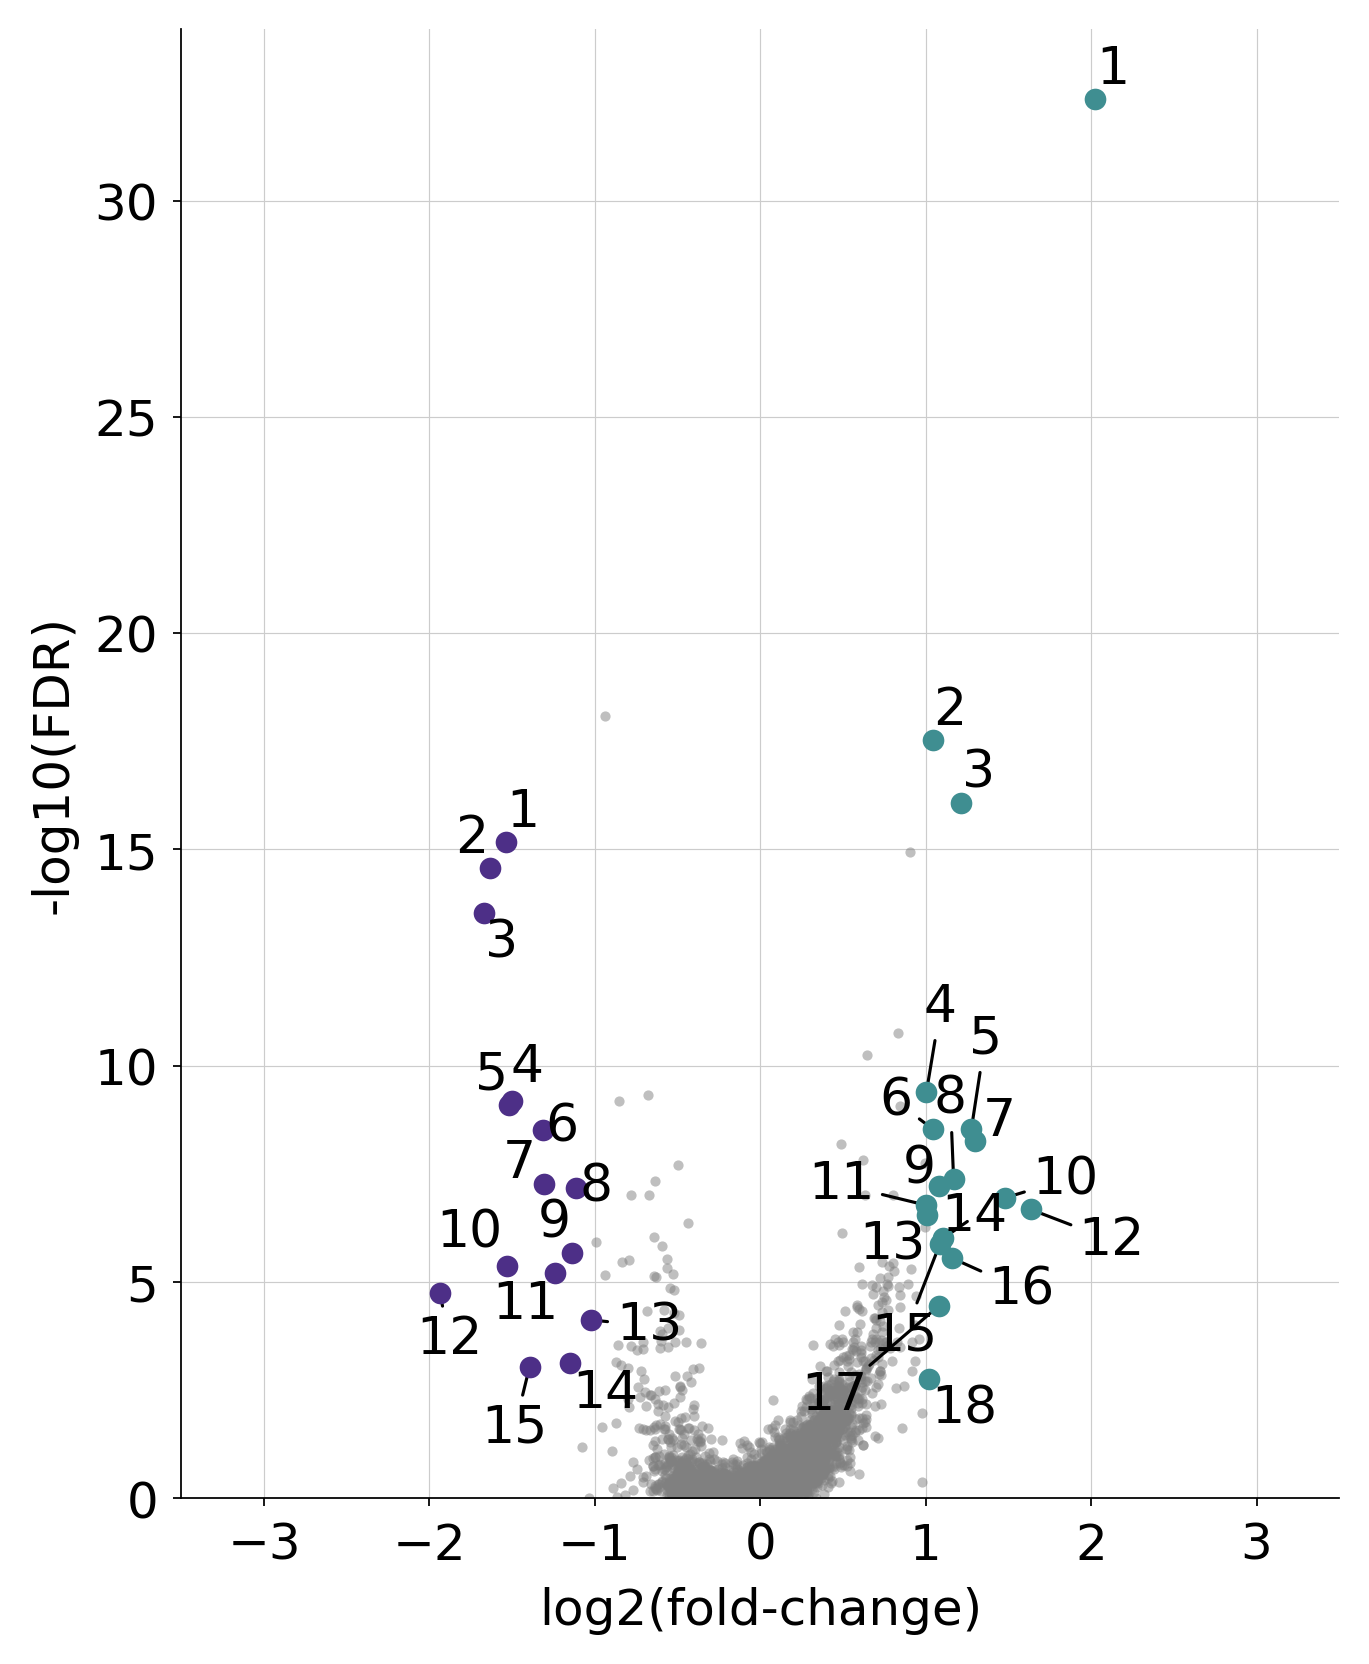

./DE_analysis/volcano_Mono1_with_names.pdf


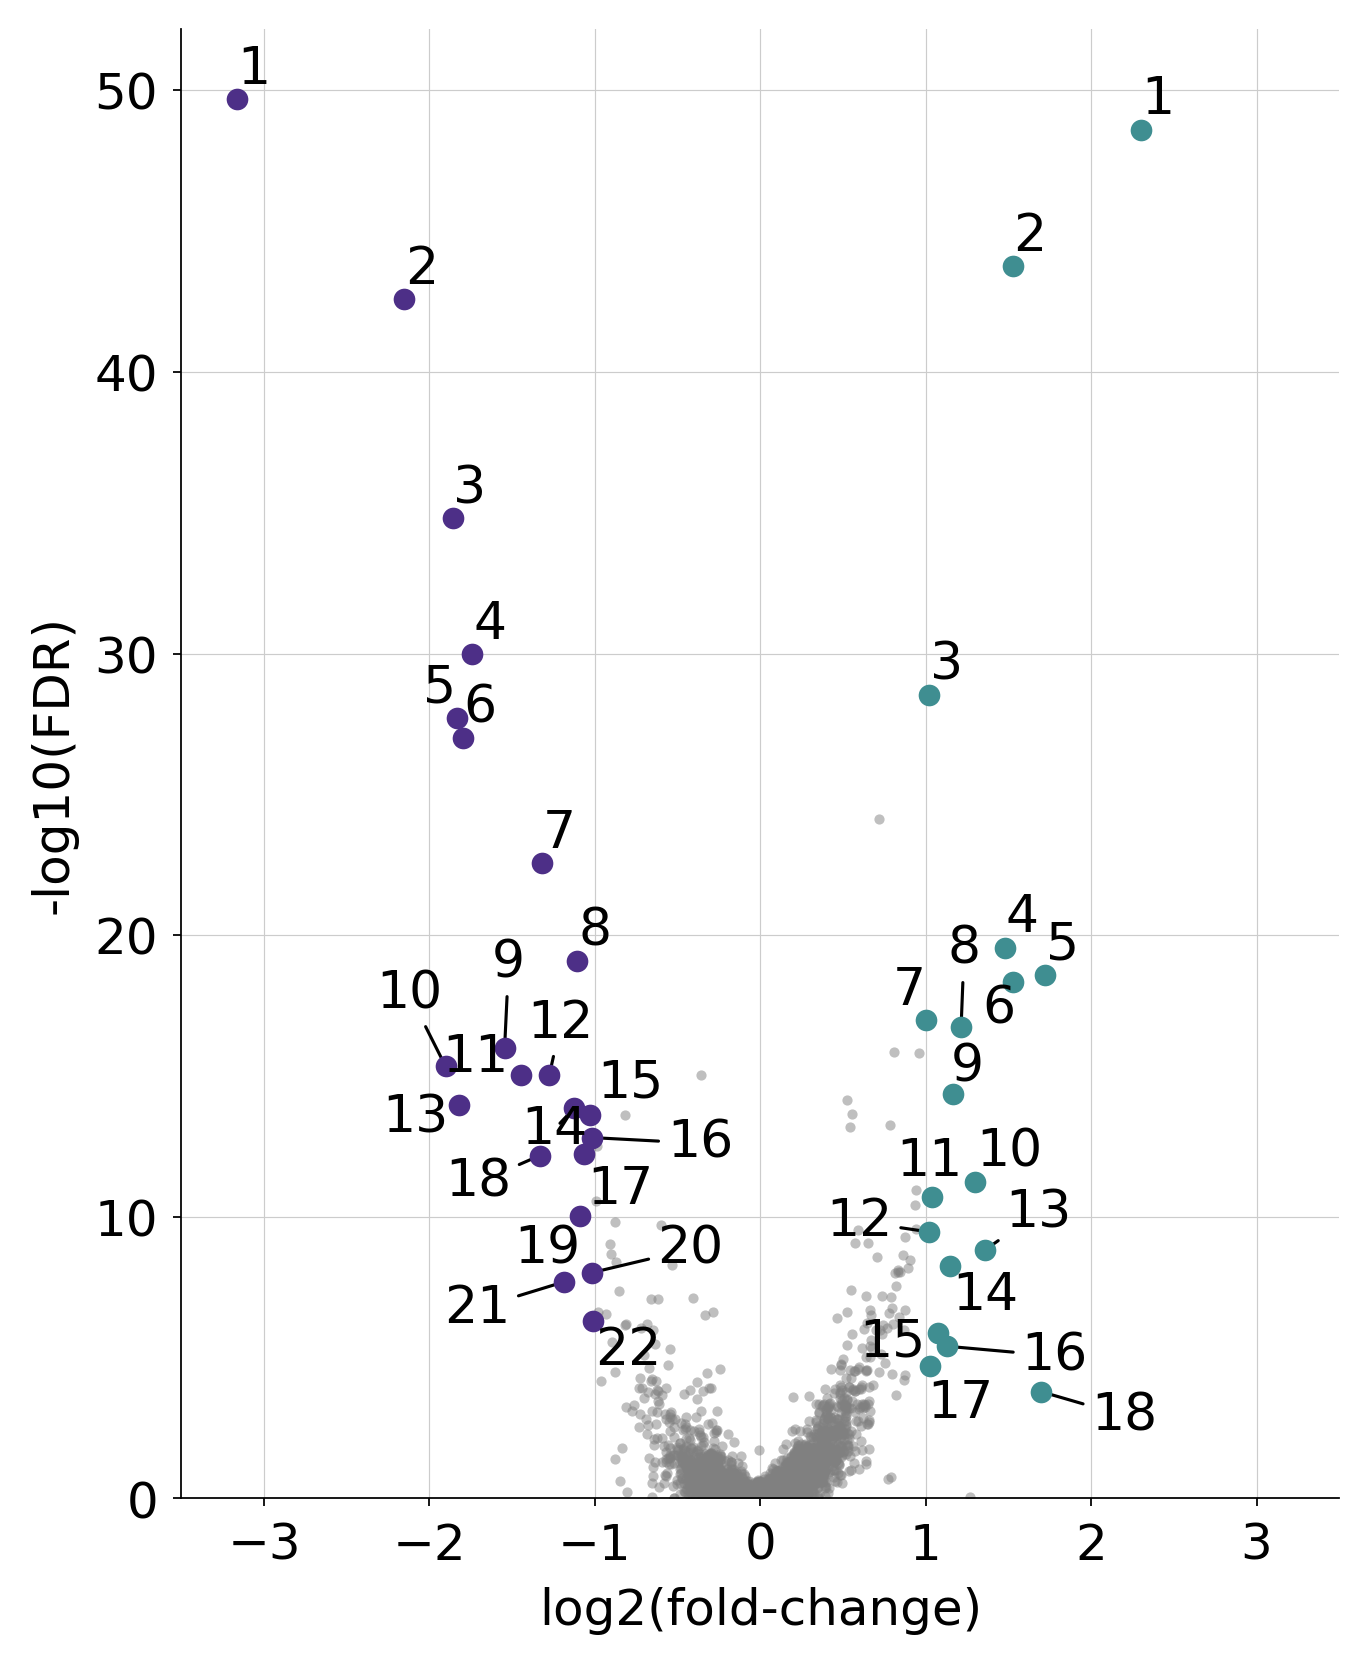

/Users/mariusmessemaker/miniconda3/envs/py36-sc/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


./DE_analysis/volcano_Mono2_with_names.pdf


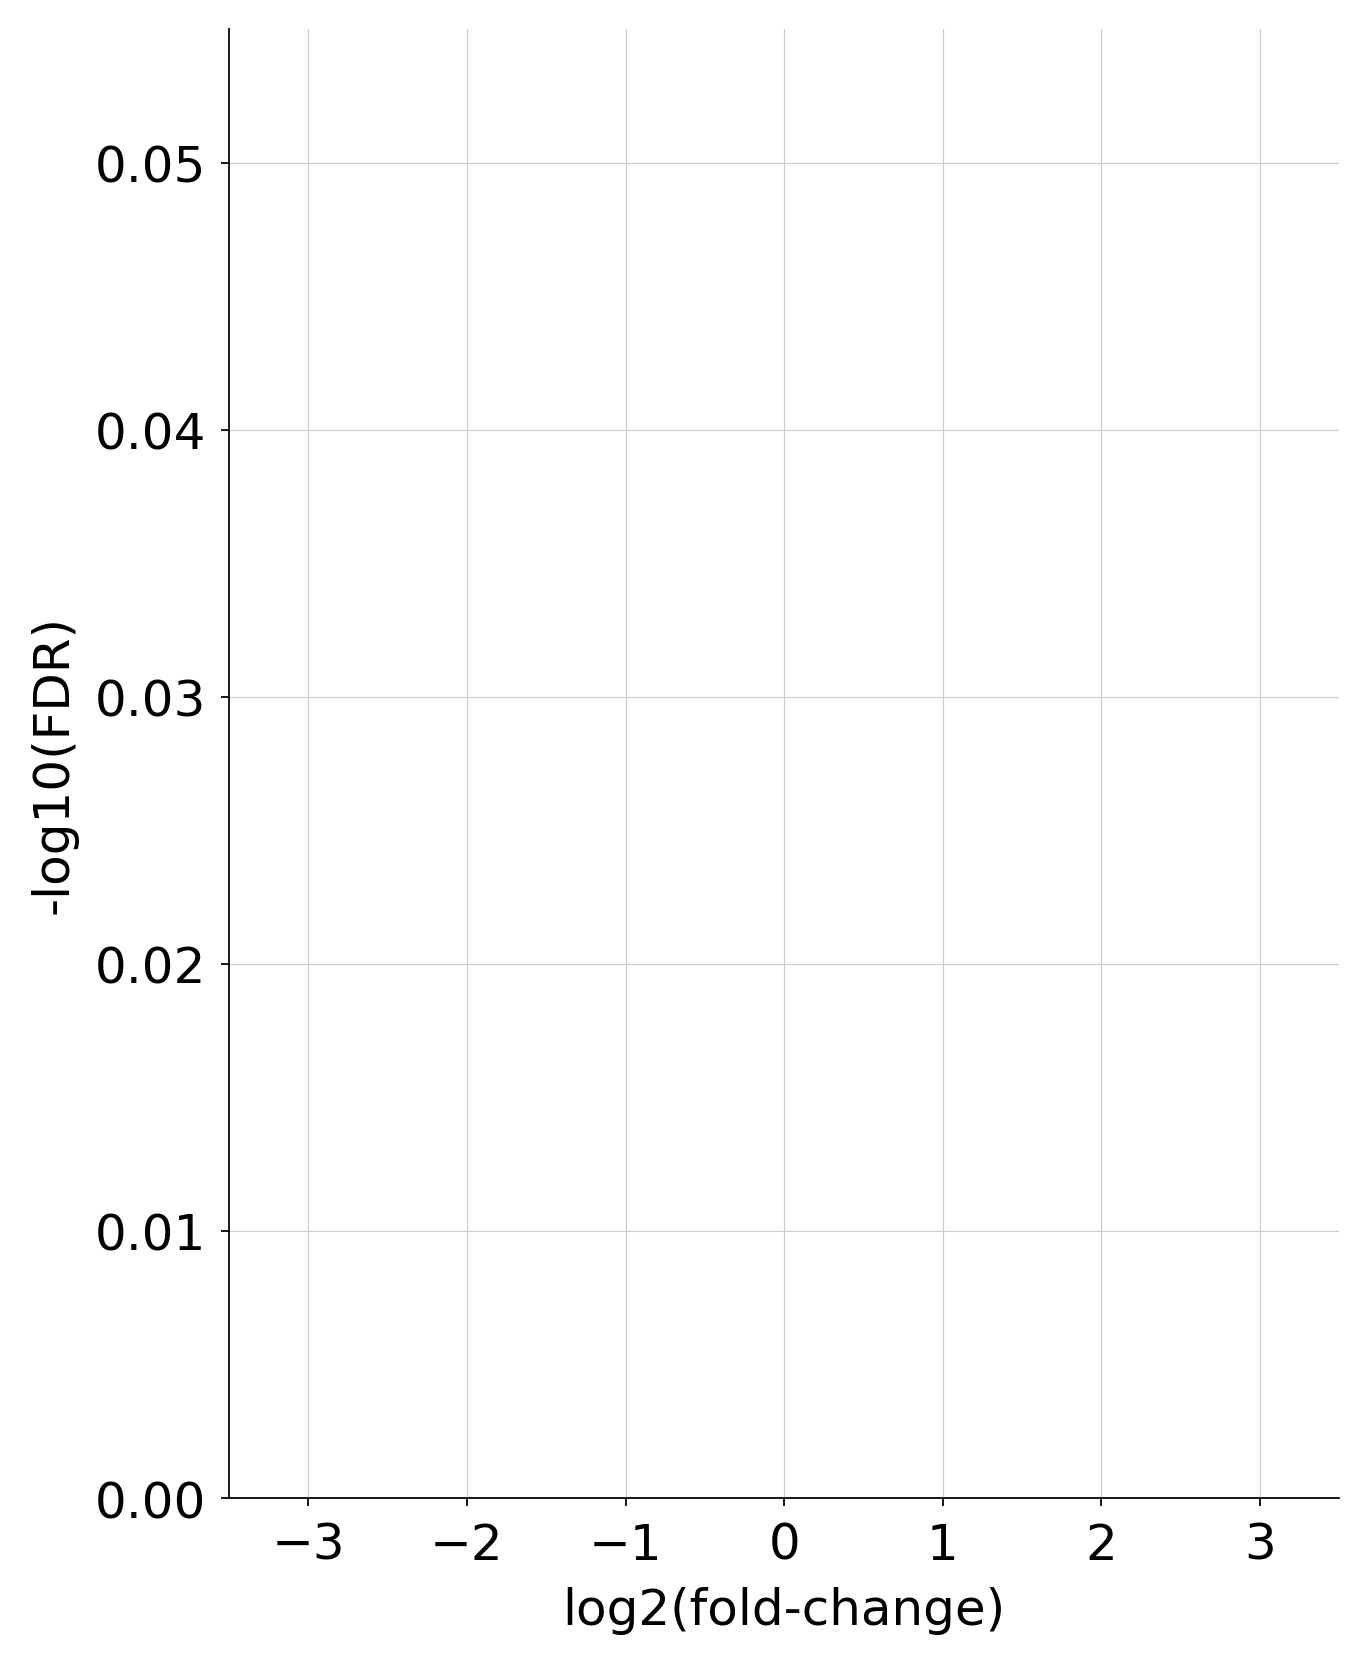

./DE_analysis/volcano_Mono3_with_names.pdf


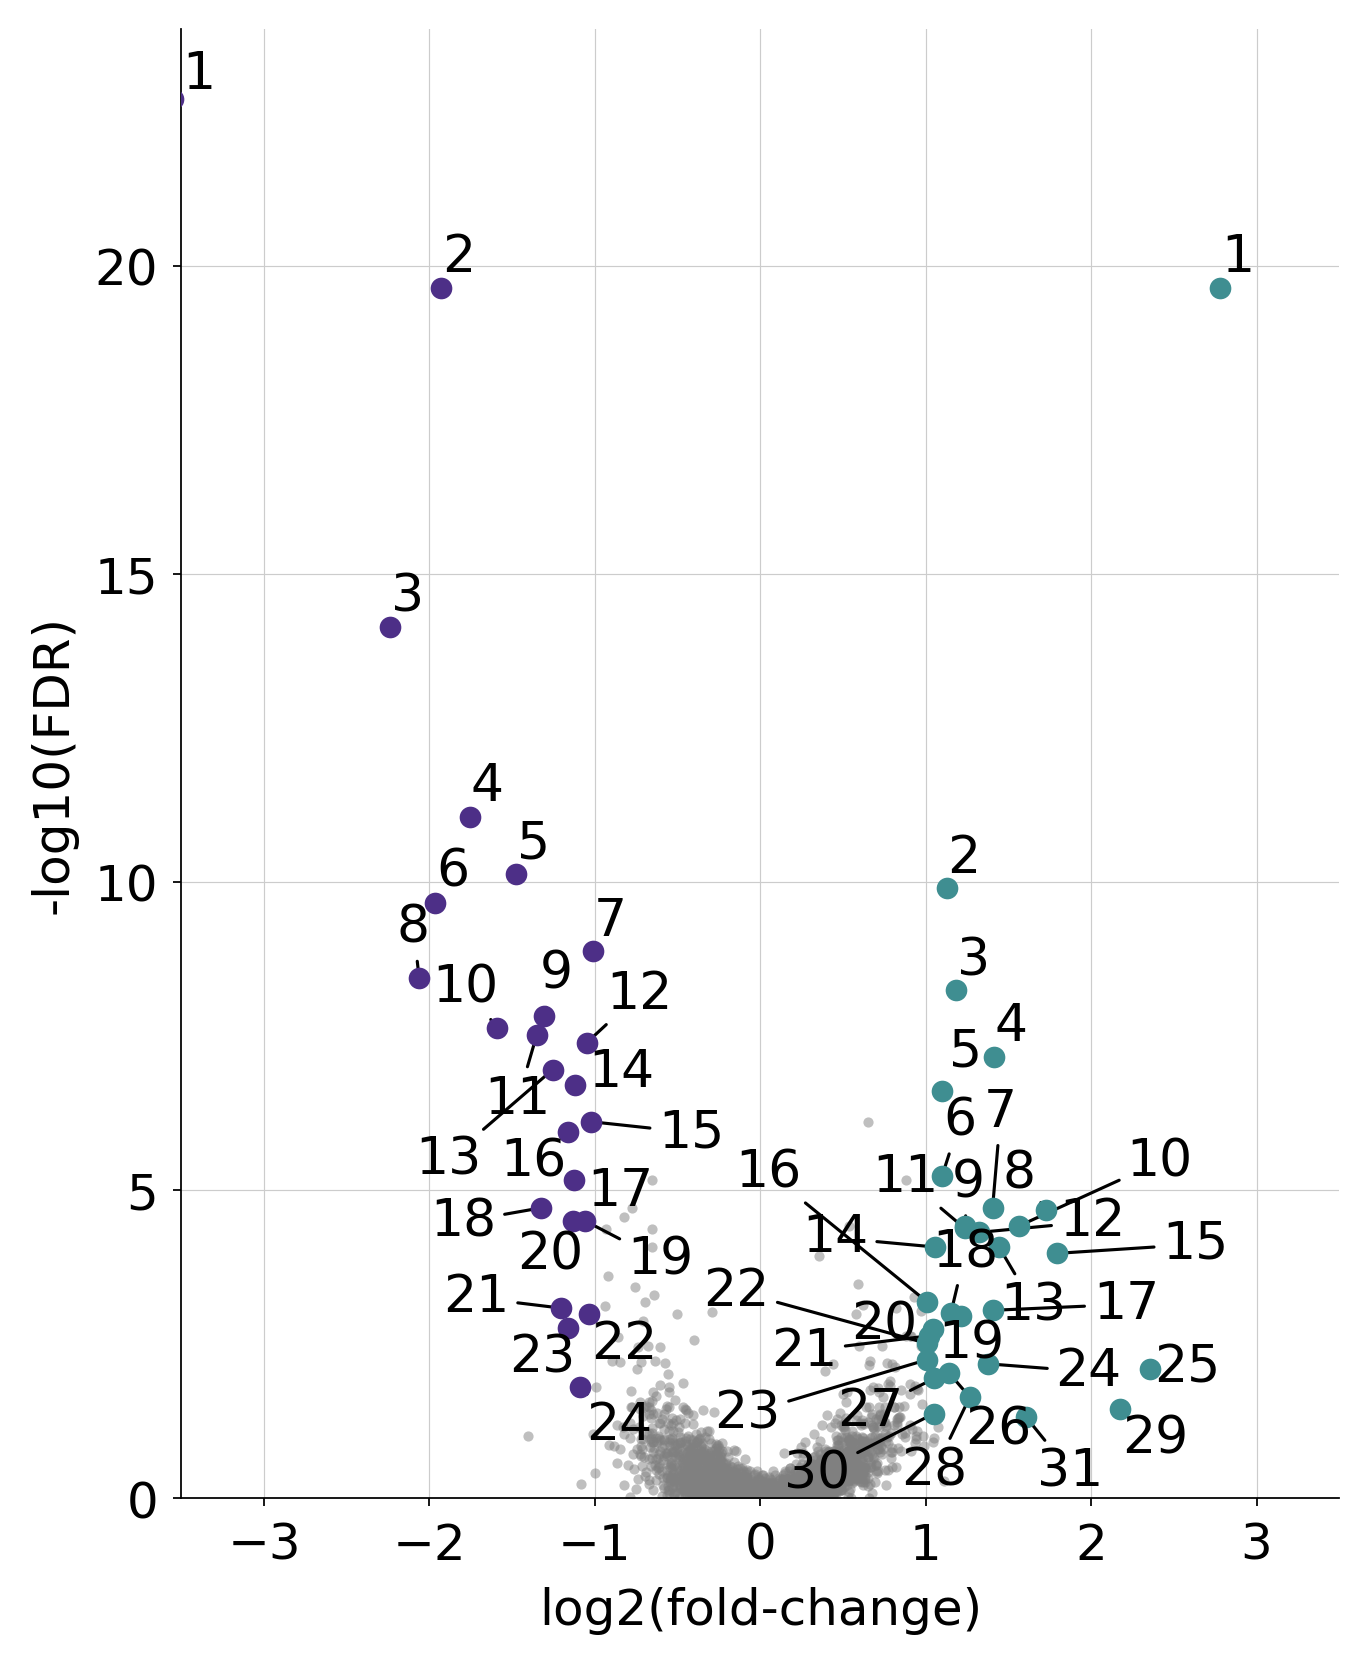

./DE_analysis/volcano_MonoDC_with_names.pdf


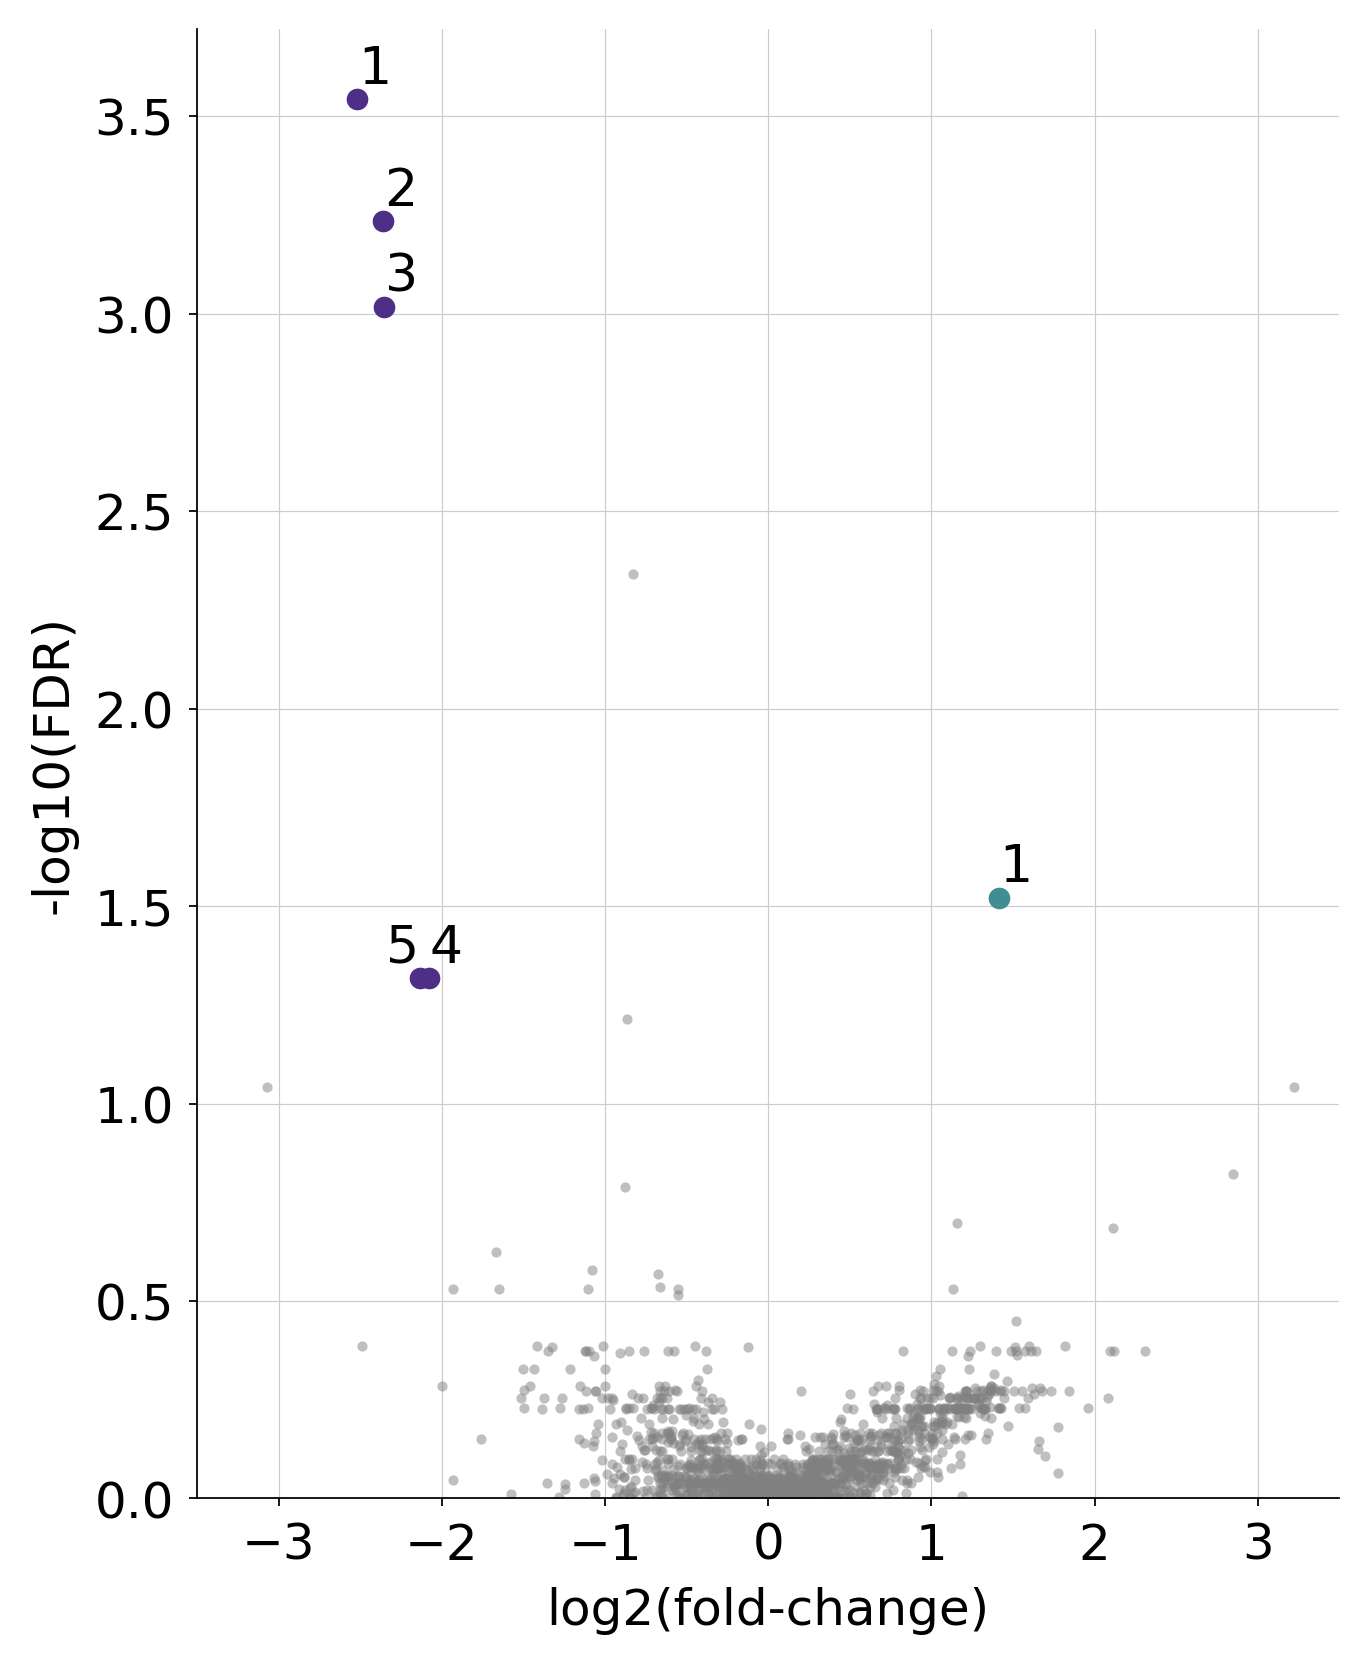

In [353]:
# iterate over population
for pop in pops:
    
    mwures = mwudict[pop]
    x = mwures['log2FC']
    y = -np.log10(mwures['fdr'])

    lw = 0
    s = 6
    c = 'grey'
    alpha = 0.5

    a,fig,gs = rz.startfig(12,14.5)
    a.scatter(x,y,lw=lw,s=s,c=c,alpha=alpha, zorder = 2)

    xmax = np.abs(a.get_xlim()).max()
    xmin = -xmax
    a.set_xlim(xmin,xmax)
    a.set_ylim(0,a.get_ylim()[1])
    rz.showspines(a,left=True,bottom=True)
    
    #a.set_ylim(bottom = 0, top = 5) # Plot the volcanos without significant DGE with a minimal 0-5 ylim
    
    a.set_xlabel('log2(fold-change)')
    a.set_ylabel('-log10(FDR)')
    a.set_xlim(-3.5, 3.5)
    a.grid(zorder = 0)

    redmask = mwures['is_DGE']
    
    iup = 1
    ido = 1 
    numberTogeneUp = {} # Save genes up in text file made from dict to make your life easier in illustator/keynote
    numberTogeneDo = {} # Save genes do in text file made from dict to make your life easier in illustator/keynote
    textsUp = []
    textsDo = []
    for gene,m,n in zip(mwures.index[redmask],x[redmask],y[redmask]):
        if m > 0: 
            a.scatter(m,n,lw=lw,s=s*4.5,c='#3F8E91',alpha=1, zorder = 6)
            numberTogeneUp[iup] = gene
            textsUp.append(plt.text(m,n,iup,fontsize=12.5, zorder = 8))
            iup += 1
        
        elif m < 0: 
            a.scatter(m,n,lw=lw,s=s*4.5,c='#4D2F87',alpha=1, zorder = 6)
            numberTogeneDo[ido] = gene 
            textsDo.append(plt.text(m,n,ido,fontsize=12.5, zorder = 8))
            ido += 1
    
    # Write gene to number tables in text files for up & down to make life in keynote/illustrator easier
    with open('./DE_analysis/volcano-%s-annotation-up.txt'%(pop), 'w') as f:
        for key, value in numberTogeneUp.items():
            f.write('%s. %s\n'%(key, value))         
    
    with open('./DE_analysis/volcano-%s-annotation-do.txt'%(pop), 'w') as f:
        for key, value in numberTogeneDo.items():
            f.write('%s. %s\n'%(key, value))
            
    gs.tight_layout(fig)
    
    # Annotate significant DGE with numbers in plot (essential that adjust_text() is called last)
    adjust_text(textsUp, 
                arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75),
                precision = 0.0000000001,
                force_text=(0.2, 0.45), 
               )
    adjust_text(textsDo, 
                arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75), 
                precision = 0.0000000001,
                force_text=(0.2, 0.45), 
               )

    plotname = './DE_analysis/volcano_%s_with_names.pdf'%(pop)
    print(plotname)
    plt.savefig(plotname,dpi=600)
    plt.show()

## Fig. S5D, S5E, S5F: DC states DE

In [18]:
# for filtering genes on abundance
min_counts = 5
min_cells = 5

# conditions to compare
condcol = 'condition'
cond1 = 'CSF1Ri'
cond2 = 'Vehicle'

# pseudo value to add for calculating fold-changes
pseudo = 1 #cp10k

# threshold for selecting DGEs
fcts = 2 #fold-change: 2-fold
fdrts = 0.05 # fdr threshold

# adata.obs column where population labels are stored
popcol = '*population'

# states to compare:
pops = [
    'DC1',
    'DC2',
    'DC3',
    'pDC'
        ]

# For storing MWU test results
mwudict = {}

# iterate over population
for pop in pops:

    # get mask for selecting all cells for a given population
    popmask = (adata.obs[popcol] == pop).values&cmask
    
    # boolean masks for selecting each population separately:
    mask1 = (adata.obs[condcol] == cond1).values&popmask
    mask2 = (adata.obs[condcol] == cond2).values&popmask
    
    
    print(pop, (mask1|mask2).sum(), 'cells')
    print('\t%s %s: %d cells'%(pop,cond1,mask1.sum()))
    print('\t%s %s: %d cells'%(pop,cond2,mask2.sum()))
    
    
    # filter genes that are lowly expressed. All cells for that population
    # combining both conditions
    gmask = srz.filter_abund_genes(adata.X[(mask1|mask2),:], min_counts, min_cells)
    
    
    cg1 = np.array(adata.X[:,gmask][mask1,:].todense())
    cg2 = np.array(adata.X[:,gmask][mask2,:].todense())
    
    mwures = rz.mwu(cg1,cg2,genes=adata.var_names[gmask],print_progression=True)
    mwures['log2FC'] = np.log2((mwures['mean1']+pseudo)/(mwures['mean2']+pseudo))
    mwures['is_DGE'] = (mwures['log2FC'].abs()>np.log2(fcts))&(mwures['fdr']<fdrts)
    mwures.sort_values(by='log2FC',ascending=False,inplace=True)
    print('%d DGEs (fold-change blz vs veh>%0.1f; FDR<%0.2f) within %s'\
          %(mwures['is_DGE'].sum(), fcts,fdrts,pop))
    
    fname = './DE_analysis/%s_blz_vs_veh.xlsx'%(pop)
    print(fname)
    mwures[mwures['is_DGE']].to_excel(fname)
    mwudict[pop] = mwures
    print()

DC1 141 cells
	DC1 CSF1Ri: 108 cells
	DC1 Vehicle: 33 cells
2698 genes passing abundance filter
1000
2000
44 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within DC1
./DE_analysis/DC1_blz_vs_veh.xlsx

DC2 262 cells
	DC2 CSF1Ri: 88 cells
	DC2 Vehicle: 174 cells
3894 genes passing abundance filter
1000
2000
3000
15 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within DC2
./DE_analysis/DC2_blz_vs_veh.xlsx

DC3 257 cells
	DC3 CSF1Ri: 157 cells
	DC3 Vehicle: 100 cells
3998 genes passing abundance filter
1000
2000
3000
18 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within DC3
./DE_analysis/DC3_blz_vs_veh.xlsx

pDC 60 cells
	pDC CSF1Ri: 59 cells
	pDC Vehicle: 1 cells
1648 genes passing abundance filter
1000
0 DGEs (fold-change blz vs veh>2.0; FDR<0.05) within pDC
./DE_analysis/pDC_blz_vs_veh.xlsx



In [19]:
# save mwuresult:
stuffname = './DE_analysis/DC_dge_analysis_results'
rz.save_stuff(mwudict,stuffname)

In [20]:
# test loading
stuffname = './DE_analysis/DC_dge_analysis_results'
mwudict = rz.load_stuff(stuffname+'.pickle')

In [21]:
# Sort values to give most significant number "1"
for key, value in mwudict.items():
    mwudict[key] = value.sort_values(by = 'fdr')

In [22]:
mwudict['DC3'].loc['Il12b', :]

U_statistic         8563
p              0.0114934
fdr              0.14634
mean1            3.84116
mean2           0.509293
log2FC           1.68148
is_DGE             False
Name: Il12b, dtype: object

In [387]:
mwudict['DC3'][mwudict['DC3']['is_DGE']==True].head(20)

,U_statistic,p,fdr,mean1,mean2,log2FC,is_DGE
Cirbp,4035.5,4.331883e-15,1.731887e-11,0.622154,3.552625,-1.488788,True
Hspa8,12272.5,2.716276e-14,5.429835e-11,32.811855,15.871696,1.002924,True
Gm42031,4546.0,1.230516e-10,1.229901e-07,0.893264,3.576954,-1.273512,True
Zmynd15,11094.0,1.356450e-09,1.084618e-06,5.111971,1.428195,1.331753,True
Anxa3,11199.5,2.002528e-09,1.334351e-06,6.670294,1.942622,1.382180,True
Gda,4961.0,2.000963e-08,9.999812e-06,2.396425,7.727853,-1.361610,True
Serpinb6b,10835.0,1.124140e-07,4.494311e-05,9.358564,3.338196,1.255657,True
Mkrn1,5088.0,3.187681e-07,9.803344e-05,1.815882,4.689676,-1.014759,True
Fnbp1,10516.0,1.248510e-06,2.495772e-04,5.278023,1.643437,1.247895,True
Ddit4,5885.0,1.202625e-06,2.495772e-04,0.388732,2.895823,-1.488160,True


./DE_analysis/volcano_DC1_with_names.pdf


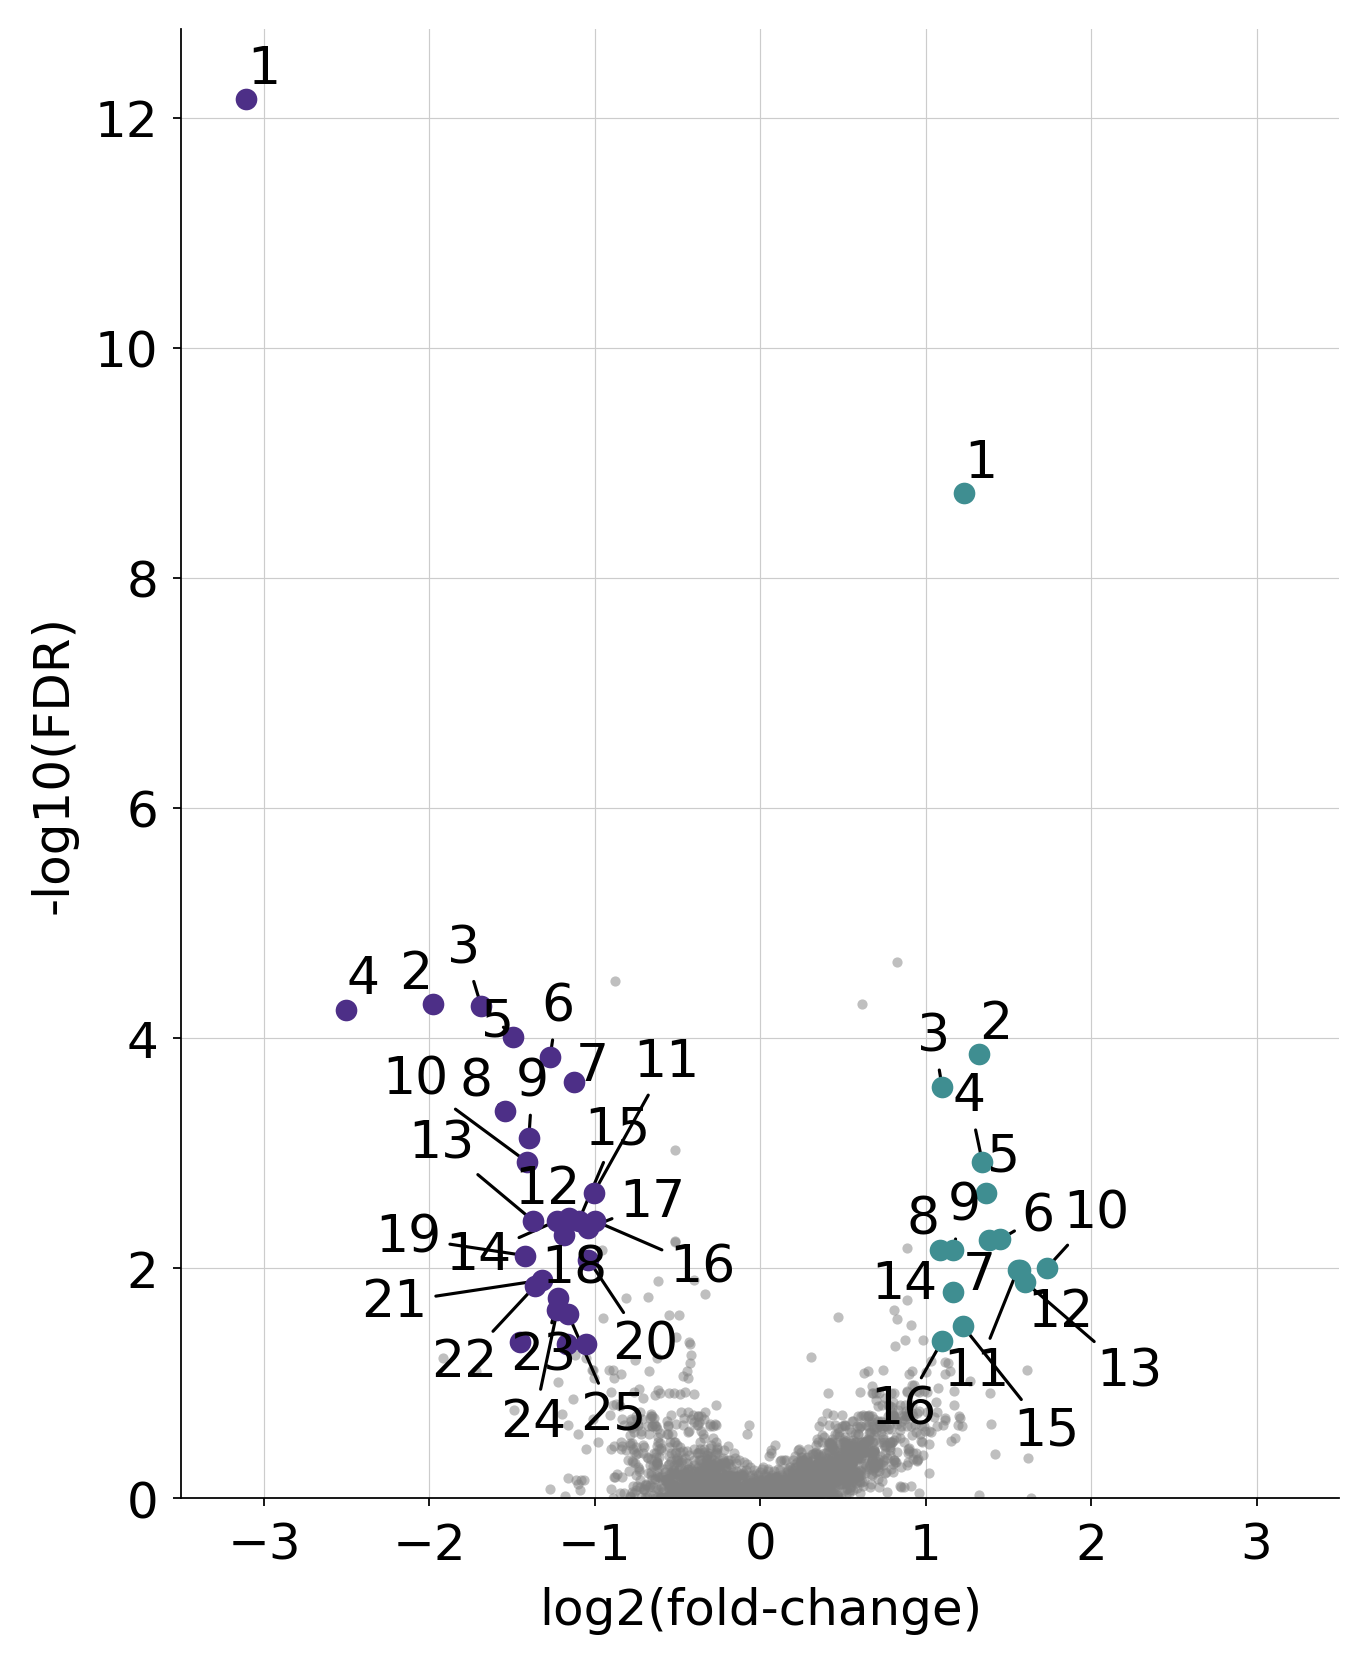

./DE_analysis/volcano_DC2_with_names.pdf


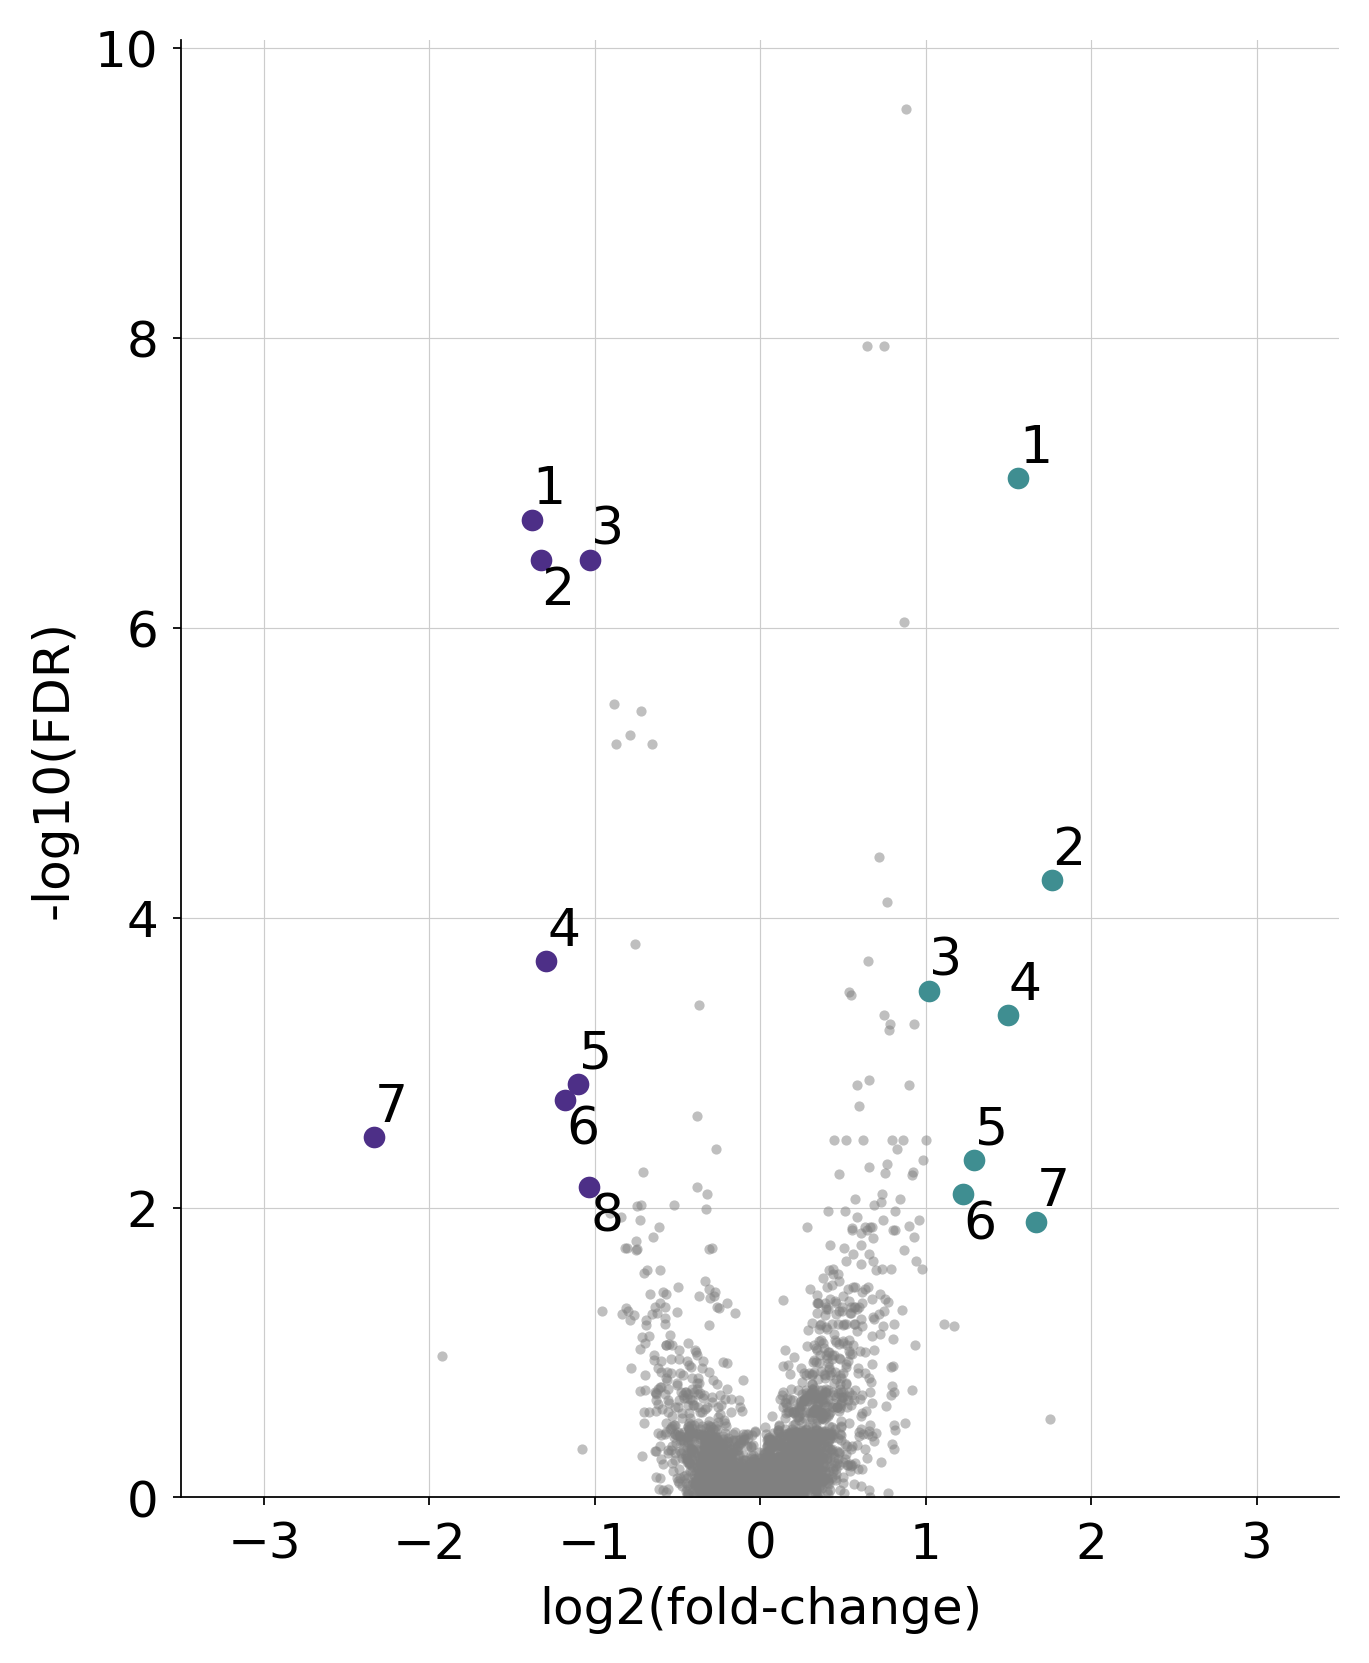

./DE_analysis/volcano_DC3_with_names.pdf


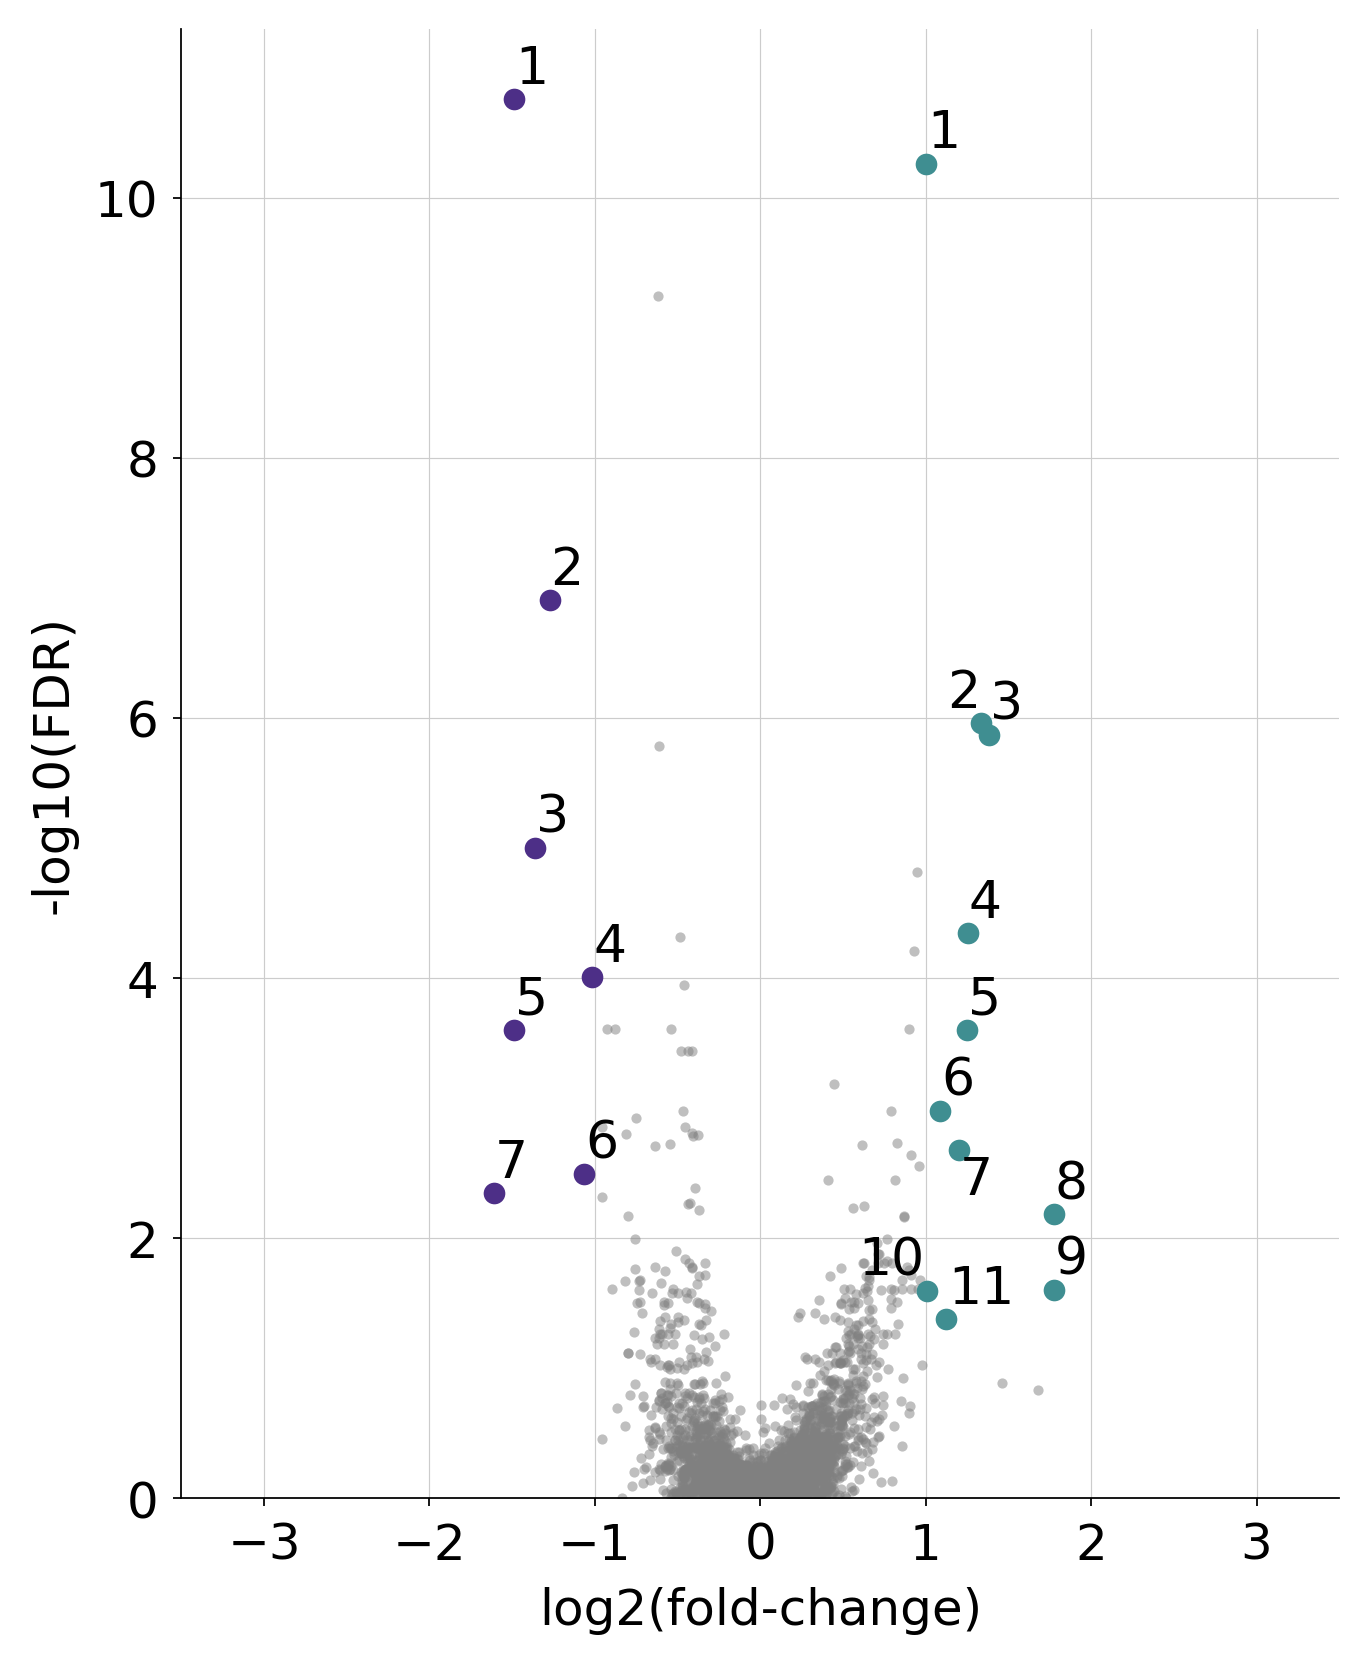

./DE_analysis/volcano_pDC_with_names.pdf


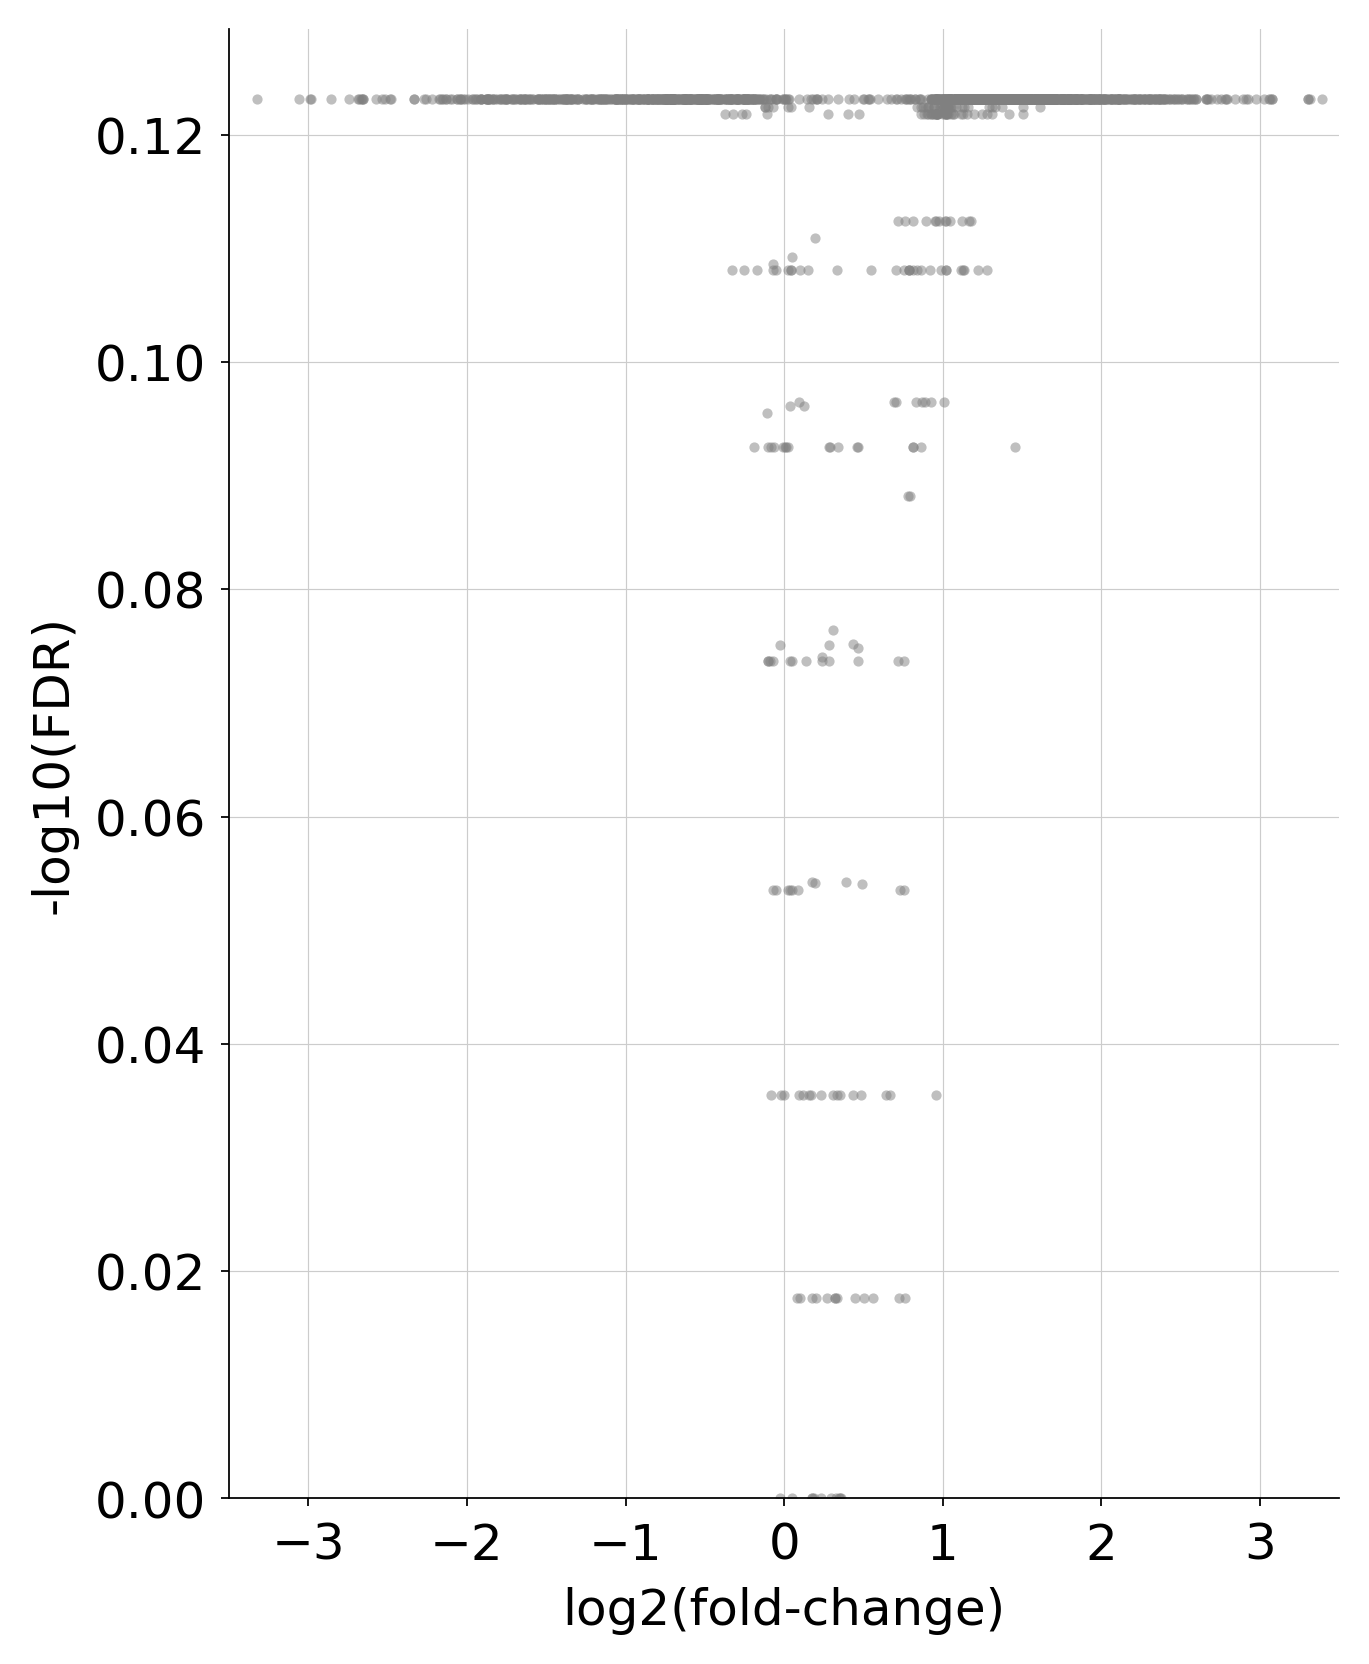

In [360]:
# iterate over population

for pop in pops:

    mwures = mwudict[pop]
    x = mwures['log2FC']
    y = -np.log10(mwures['fdr'])

    lw = 0
    s = 6
    c = 'grey'
    alpha = 0.5

    a,fig,gs = rz.startfig(12,14.5)
    a.scatter(x,y,lw=lw,s=s,c=c,alpha=alpha, zorder = 2)

    xmax = np.abs(a.get_xlim()).max()
    xmin = -xmax
    a.set_xlim(xmin,xmax)
    a.set_ylim(0,a.get_ylim()[1])
    rz.showspines(a,left=True,bottom=True)
    
    #a.set_ylim(bottom = 0, top = 5) # Plot the volcanos without significant DGE with a minimal 0-5 ylim

    a.set_xlabel('log2(fold-change)')
    a.set_ylabel('-log10(FDR)')
    a.set_xlim(-3.5, 3.5)
    a.grid(zorder = 0)

    redmask = mwures['is_DGE']
    
    iup = 1
    ido = 1 
    numberTogeneUp = {} # Save genes up in text file made from dict to make your life easier in illustator/keynote
    numberTogeneDo = {} # Save genes do in text file made from dict to make your life easier in illustator/keynote
    textsUp = []
    textsDo = []
    for gene,m,n in zip(mwures.index[redmask],x[redmask],y[redmask]):
        if m > 0: 
            a.scatter(m,n,lw=lw,s=s*4.5,c='#3F8E91',alpha=1, zorder = 6)
            numberTogeneUp[iup] = gene
            if iup <= 25: # One plot had too many genes to plot added limit of most significant 25 genes to annotate
                textsUp.append(plt.text(m,n,iup,fontsize=12.5, zorder = 8)) # Font 9 & 9,11
            iup += 1
        
        elif m < 0: 
            a.scatter(m,n,lw=lw,s=s*4.5,c='#4D2F87',alpha=1, zorder = 6)
            numberTogeneDo[ido] = gene 
            if ido <= 25: # One plot had too many genes to plot added limit of most significant 25 genes to annotate
                textsDo.append(plt.text(m,n,ido,fontsize=12.5, zorder = 8))
            ido += 1
    
    # Write gene to number tables in text files for up & down to make life in keynote/illustrator easier
    with open('./DE_analysis/volcano-%s-annotation-up.txt'%(pop), 'w') as f:
        for key, value in numberTogeneUp.items():
            f.write('%s. %s\n'%(key, value))         
    
    with open('./DE_analysis/volcano-%s-annotation-do.txt'%(pop), 'w') as f:
        for key, value in numberTogeneDo.items():
            f.write('%s. %s\n'%(key, value))
            
    gs.tight_layout(fig)
    
    # Annotate DGE genes with numbers in plot (essential that adjust_text() is called last)
    adjust_text(textsUp, 
                arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75),
                precision = 0.0000000001,
                force_text=(0.2, 0.45), 
               )
    adjust_text(textsDo, 
                arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75), 
                precision = 0.0000000001,
                force_text=(0.2, 0.45), 
               )

    plotname = './DE_analysis/volcano_%s_with_names.pdf'%(pop)
    print(plotname)
    plt.savefig(plotname,dpi=600)
    plt.show()